## Spike Processing Pipeline ver 0.2
This notebook specifes a preprocessing pipeline for neural data colleted on blackrock aquisition devices in the Hatsopoulos lab. The file assumes that spikeinterface(ver 0.13 - 0.10), python-neo, matplotlib, numpy, PHY, and pandas are installed.

The code needs a datafile (ns6) and a probe file (you can find tony's its at /Paul/prbfiles/TY_array.prb). This script will automatically precondition the data (filtering and referencing), attach probe infomation (via .prb file) and pull out LFP data. The file will then sort the neural data with a number of different sorters, and comparitive sort to find the units common to all of the sorters (see https://elifesciences.org/articles/61834 ). Finally, it will convert the automatic sorting of one sorter (It is recommened to use IronClust as your primary sorter) and mark the common units as 'good' in the phy output.

The user would then mark each cluster as good (SU), MUA (multiunit), or noise. For analysis, you could read the phy output directly (numpy files) or you could inmport back to spikeinterface and save.

Useful web sites:
spikeinterface docs (for old api): https://spikeinterface.readthedocs.io/en/0.13.0/
phy docs: https://phy.readthedocs.io/en/latest/
Useful info about .prb files): https://tridesclous.readthedocs.io/en/latest/important_details.html
                               https://spyking-circus.readthedocs.io/en/latest/code/probe.html

## preprocessing --SESSION NAME--

In [2]:
# import the necessary toolboxes. Note unknown installation problem with matplotlib. Run this cell 2x. Will complain
# but ok.

import matplotlib.pyplot as plt
import spikeinterface
import spikeinterface.extractors as se 
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import numpy as np
import pandas as pd
from os.path import join as pjoin
import os
import glob
import pynwb

# specify inline plotting
%matplotlib notebook

In [3]:
# User defined information about the data

pth = '/project2/nicho/marmoset_tempStorage/electrophys_data_for_processing' # path to data directory
sess = 'TY20221024_testbattery' # directory where Ns6 file lives
file = 'TY20221024_testbattery_001.ns6' # name of NS6 file
prbfile = '/project/nicho/data/marmosets/prbfiles/TY_array.prb' # name of probe (.prb) file

# User defined paths to sorters
sorters_dir    = '/project/nicho/environments/matlabtools'
kilosort_path  = pjoin(sorters_dir, 'Kilosort-2.5/')
ironclust_path = pjoin(sorters_dir, 'ironclust/')
waveclus_path  = pjoin(sorters_dir, 'wave_clus/')

## Run the next cell to reload a recording that has already been prepared for spikesorting

In [4]:
# load up from save: If you need to reload the data above, you can just run this cell
try:
    recording_cache = se.load_extractor_from_pickle(pjoin(pth, sess, 'processed/recording.pkl'))
    # check the channel properties are correct
    recording_cache.get_shared_channel_property_names()
    
    print('Skip subsequent steps until you reach the "Spike Sorting" header')

except:
    print('The processed recording does not exist at %s.\n\n Continue on to "Load Unprocessed Data" and "Preprocessing" sections' % pjoin(pth, sess, 'processed/recording.pkl'))

The processed recording does not exist at /project2/nicho/marmoset_tempStorage/electrophys_data_for_processing/TY20221024_testbattery/processed/recording.pkl.

 Continue on to "Load Unprocessed Data" and "Preprocessing" sections


In [ ]:
X:\marmoset_tempStorage\electrophys_data_for_processing\TY20221024_testbattery\processed

## Load Unprocessed Data

In [5]:
def load_recording_and_prbfile(recording_folder, prbfile):
    # load recording
    recording = se.BlackrockRecordingExtractor(recording_folder, nsx_to_load=6)
    # load probe information
    recording_prb = recording.load_probe_file(prbfile)
    
    return recording_prb

In [46]:
# Load recording and probefile
recording_folder = pjoin(pth, sess, file)
print('recording_folder: ', recording_folder)
print('probefile: ', prbfile)

recording_prb = load_recording_and_prbfile(recording_folder, prbfile)

# check that info correct properties are present (should be gain, group, location, name, and offset)
recording_prb.get_shared_channel_property_names()

recording_folder:  /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/TY20221024_testbattery_001.ns6
probefile:  /project/nicho/data/marmosets/prbfiles/TY_array.prb


<IPython.core.display.Javascript object>


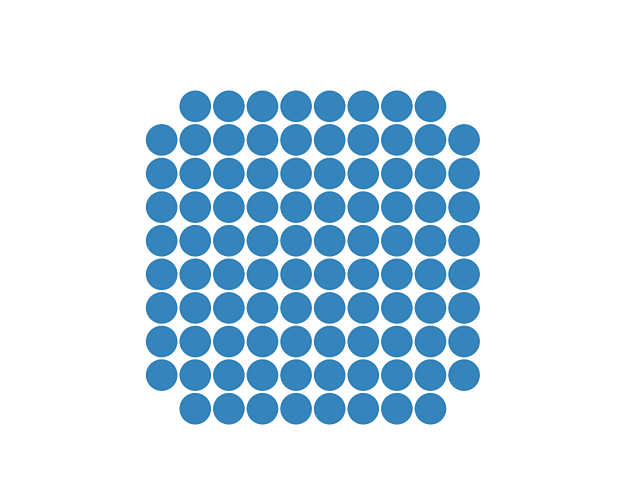

In [48]:
# visualize probe geometry: want to see that it looks correct
w_elec = sw.plot_electrode_geometry(recording_prb)

## Preprocessing
First step is common median filtering (the median across all channels is removed sample wise from the signal at each probe). Then the signal at each channel is low pass filtered and saved off as the lfp. The data is then bandpass filtered for spike processing. The filter values can be set, the defaults are 350Hz for LFP and 350-7500Hz for spikes. Some plots to review the data and save progress. The spike data is saved as a cache. All of the filtering is only done when the data is read. So to save time in future steps, we save the filtered/processed data to file.

In [51]:
# automagically attempt top find bad channels. need to then specify them in next cell by 
# editing channels_to_remove. Enter exactly the list that is printed here (output in base-0, enter in base-0).
st.preprocessing.remove_bad_channels(recording_prb, verbose=True)
print('(Channels not actually removed. Edit "channels_to_remove = []" in the next cell to match this output)')

Automatically removing channels: [33, 66]
(Channels not actually removed. Edit "channels_to_remove = []" in the next cell to match this output)


In [52]:
# Specify any channels to remove: Default list of channels_to_remove should be empty.

channels_to_remove = [33, 66]


In [53]:
# defining next few steps within a function so intermediate recording_ variables don't hold on to RAM
def process_raw_recording(recording_prb, channels_to_remove):
    
    # condition the signal for the lfp
    # lowpass filter for lfp
    recording_lp = st.preprocessing.bandpass_filter(recording_prb, freq_min=1, freq_max=350, filter_type='butter')
    # downsample
    recording_lfp = st.preprocessing.resample(recording_lp, resample_rate=1000)
    
    # remove bad channels or set recording_rmc to unaltered recording_prb
    if len(channels_to_remove) > 0:
        channels_to_remove = [ch+1 for ch in channels_to_remove]
        recording_rmc = st.preprocessing.remove_bad_channels(recording_prb, bad_channel_ids=channels_to_remove)
    else:
        recording_rmc = recording_prb

    # verify that all of the properties were trnasfered to the new recording object
    print('properties: ', recording_rmc.get_shared_channel_property_names())
    # verify bad channels have been removed
    print('ids: ', recording_rmc.get_channel_ids())    
    
    # bandpass filter for spikes, then common median reference
    recording_f = st.preprocessing.bandpass_filter(recording_rmc, freq_min=350, freq_max=7500, filter_type='butter')
    recording_cmr = st.preprocessing.common_reference(recording_f, reference='median')
    
    return recording_lfp, recording_cmr


In [54]:
recording_lfp, recording_cmr = process_raw_recording(recording_prb, channels_to_remove)

properties:  ['gain', 'group', 'location', 'name', 'offset']
ids:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96]


<IPython.core.display.Javascript object>


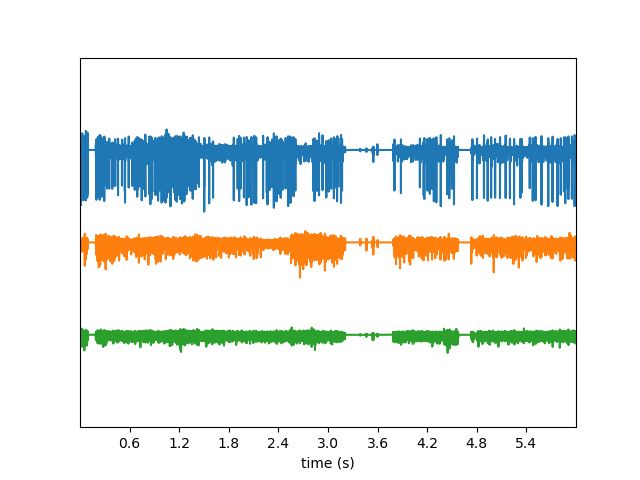

In [55]:
# view the signal on channels. channel_id is the probe and trange is the time sample to view in seconds
sw.plot_timeseries(recording_cmr, channel_ids=[2, 5, 7], trange=[0, 6])

<IPython.core.display.Javascript object>


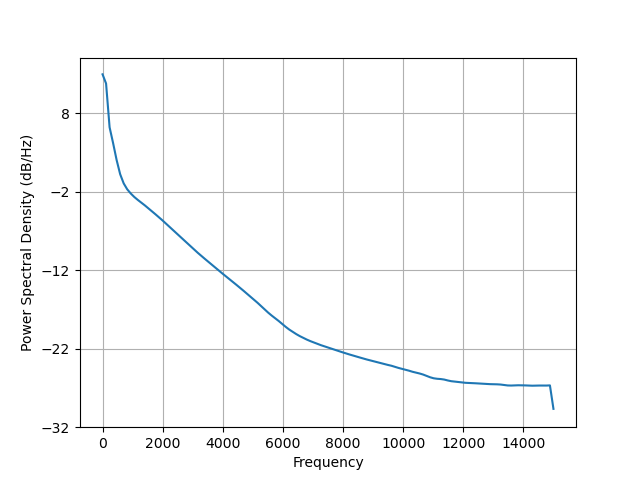

In [56]:
# view the power spectrum of the data. Check that the filtering looks reasonable. You can also look at the
# the raw data: recording, or the lfp: recording_lfp, or the spike data: recording_f
w_sp = sw.plot_spectrum(recording_prb, channels=[5])

In [62]:
# save preprocessed data for spikes and cache recording
recording_cache = se.CacheRecordingExtractor(recording_cmr, save_path=pjoin(pth, sess, 'processed/filtered_data.dat'))
recording_cache.dump_to_dict()
print('finished saving %s' % pjoin(pth, sess, 'processed/filtered_data.dat'))
recording_cache.dump_to_pickle(pjoin(pth, sess, 'processed/recording.pkl'))
print('finished saving %s' % pjoin(pth, sess, 'processed/recording.pkl'))
# save preprocessed data for lfp
se.CacheRecordingExtractor(recording_lfp, save_path=pjoin(pth, sess, 'processed/lfp_data.dat'))
print('finished saving %s' % pjoin(pth, sess, 'processed/lfp_data.dat'))


## Spike Sorting
First step is to set the parameters for the sorters. Then call each sorter that you want to run. Each run will make its own folder with the sorting results and save the results. You can also add aditional sorters. For example if you want to add YASS you can follow the pattern set here. See the documentation to install.

In [5]:
# set the paths for the sorters you want to run
ss.Kilosort2_5Sorter.set_kilosort2_5_path(kilosort_path)
ss.IronClustSorter.set_ironclust_path(ironclust_path)
ss.WaveClusSorter.set_waveclus_path(waveclus_path)

Setting KILOSORT2_5_PATH environment variable for subprocess calls to: /project/nicho/environments/matlabtools/Kilosort-2.5
Setting IRONCLUST_PATH environment variable for subprocess calls to: /project/nicho/environments/matlabtools/ironclust
Setting WAVECLUS_PATH environment variable for subprocess calls to: /project/nicho/environments/matlabtools/wave_clus


In [6]:
# check which sorters are installed
ss.installed_sorters()

['ironclust',
 'kilosort2_5',
 'klusta',
 'spykingcircus',
 'tridesclous',
 'waveclus']

## Spyking Circus
Spyking circus nicely complains when an electrode is too corrupted to sort, so run this first and check to see if there are any problem electrodes. You can find which channels didn't get sorted by searching the results, each probe has its own folder, so search: ls results_sc/?/recording/*result.hdf5.  If so, you can go back and exclude those probes from the analysis by inserting the problematic probe numbers into the previous cell for exluding probes (don't forget that the probes will be in python 0-based, and you need to specify in the cell above the probe number in 1-based system). When bad electrodes are found Spyking Circus will tell you in the log which probe it is, then it will crash just before it completes. You can find the bad probes becuase they will be missing a *recording.result.hdf5* file in that probes recording directory (for ex. for the first probe the file would be located at processed/results_sc/0/recording/). Once you get spyking circus to run through to completion, everything else should work no problem.

In [7]:
# Start with spyking circus. list the parameters for the sorter
ss.get_params_description('spykingcircus')

{'detect_sign': 'Use -1 (negative), 1 (positive) or 0 (both) depending on the sign of the spikes in the recording',
 'adjacency_radius': 'Radius in um to build channel neighborhood',
 'detect_threshold': 'Threshold for spike detection',
 'template_width_ms': 'Template width in ms. Recommended values: 3 for in vivo - 5 for in vitro',
 'filter': 'Enable or disable filter',
 'merge_spikes': 'Enable or disable automatic mergind',
 'auto_merge': 'Automatic merging threshold',
 'num_workers': 'Number of workers (if None, half of the cpu number is used)',
 'whitening_max_elts': 'Max number of events per electrode for whitening',
 'clustering_max_elts': 'Max number of events per electrode for clustering'}

In [8]:
# see what the default parameters are. These are the only parameters spikeinterface will let you modify.
ss.get_default_params('spykingcircus')

{'detect_sign': -1,
 'adjacency_radius': 100,
 'detect_threshold': 6,
 'template_width_ms': 3,
 'filter': True,
 'merge_spikes': True,
 'auto_merge': 0.75,
 'num_workers': None,
 'whitening_max_elts': 1000,
 'clustering_max_elts': 10000}

In [9]:
# set your own parameter values
params = {'detect_sign': -1,
 'adjacency_radius': 100,
 'detect_threshold': 6,
 'template_width_ms': 3,
 'filter': False,
 'merge_spikes': True,
 'auto_merge': 0.75,
 'num_workers': 48,
 'whitening_max_elts': 1000,
 'clustering_max_elts': 10000}

In [8]:
# run the sorter
sorting_SC = ss.run_spykingcircus(recording_cache, 
                                  output_folder=pjoin(pth, sess, 'processed/results_sc'), 
                                  grouping_property='group',
                                  n_jobs=16,
                                  verbose=True, 
                                  **params)
print(f'SpykingCircus found {len(sorting_SC.get_unit_ids())} units')

# find bad channels from spyking circus output
sc_channel_folders = glob.glob(pjoin(pth, sess, 'processed/results_sc', '*'))
bad_chans = []
for chfold in sc_channel_folders:
    good_chan = os.path.exists(pjoin(chfold, 'recording', 'recording.result.hdf5'))
    if not good_chan:
        bad_chans.append(int(os.path.basename(chfold)))
bad_chans = sorted(bad_chans)

print('bad_channels from spykingcircus are %s' % bad_chans)

# If no bad channels, save sorting results in case of crash
if len(bad_chans) == 0:
    sorting_SC.dump_to_dict()
    sorting_SC.dump_to_pickle(pjoin(pth, sess, 'processed/sorting_sc.pkl'))

RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_sc/0/run_spykingcircus.sh


##################################################################

#####             Welcome to the SpyKING CIRCUS              #####

#####                        (1.1.0)                         #####

#####             Written by P.Yger and O.Marre              #####

##################################################################





File          : /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_sc/0/recording.npy

Steps         : filtering, whitening, clustering, fitting, merging

Number of CPU : 48/48

Parallel HDF5 : False

Shared memory : True

Hostfile      : /home/daltonm/spyking-circus/circus.hosts



##################################################################





-------------------------  Informations  -------------------------

| Number of recorded channe

 46%|████████████████▌                   |[00:04<00:05, 82.50it/s]

 48%|█████████████████▏                  |[00:04<00:04, 93.94it/s]

 49%|█████████████████▋                  |[00:04<00:04, 94.25it/s]

 51%|██████████████████▏                 |[00:04<00:04, 91.08it/s]

 52%|██████████████████▋                 |[00:04<00:04, 86.63it/s]

 53%|███████████████████                 |[00:04<00:04, 75.77it/s]

 55%|███████████████████▊                |[00:04<00:03, 92.55it/s]

 56%|████████████████████▎               |[00:04<00:03, 91.89it/s]

 58%|████████████████████▎              |[00:04<00:03, 103.16it/s]

 59%|████████████████████▊              |[00:05<00:03, 100.61it/s]

 61%|█████████████████████▉              |[00:05<00:03, 85.09it/s]

 62%|██████████████████████▍             |[00:05<00:03, 85.14it/s]

 63%|██████████████████████▊             |[00:05<00:03, 86.21it/s]

 65%|███████████████████████▎            |[00:05<00:03, 87.12it/s]

 66%|███████████████████████▊            |[00:05

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:01<00:00,  1.78s/it]

100%|████████████████████████████████████|[00:01<00:00,  1.78s/it]

-------------------------  Informations  -------------------------

| Templates on few channels only (1), cc_merge set to 1 automatically

------------------------------------------------------------------



Removing mixtures of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 18.10it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|██████████████████████████████████|[00:00<00:00, 1822.82it/s]

-------------------------  Informations  -------------------------

| Number of global merges    : 0

| Number of mixtures removed : 0

------------------------------------------------------------------



Computing optimal amplitudes for the templates...



  0%|            

-------------------------  Informations  -------------------------

| We kept 28 templates out of 28 after merging

| As meta merging is still experimental, you need

| to use the extension option to see its results

| >> circus-gui-matlab mydata.dat -e merged

| or

| >> spyking-circus mydata.dat -m converting -e merged

------------------------------------------------------------------



RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_sc/2/run_spykingcircus.sh


##################################################################

#####             Welcome to the SpyKING CIRCUS              #####

#####                        (1.1.0)                         #####

#####             Written by P.Yger and O.Marre              #####

##################################################################





File          : /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processe

 36%|█████████████                       |[00:03<00:06, 81.15it/s]

 37%|█████████████▍                      |[00:03<00:05, 83.26it/s]

 39%|█████████████▉                      |[00:03<00:05, 89.55it/s]

 40%|██████████████▍                     |[00:03<00:05, 91.78it/s]

 41%|██████████████▊                     |[00:03<00:05, 83.61it/s]

 42%|███████████████▎                    |[00:03<00:05, 83.56it/s]

 44%|███████████████▋                    |[00:04<00:05, 83.76it/s]

 45%|████████████████▎                   |[00:04<00:04, 94.51it/s]

 47%|████████████████▊                   |[00:04<00:04, 85.66it/s]

 48%|█████████████████▎                  |[00:04<00:04, 92.62it/s]

 50%|█████████████████▊                  |[00:04<00:04, 89.05it/s]

 51%|██████████████████▎                 |[00:04<00:04, 81.32it/s]

 53%|██████████████████▉                 |[00:04<00:04, 91.00it/s]

 54%|███████████████████▎                |[00:04<00:04, 85.97it/s]

 55%|███████████████████▊                |[00:05

Searching random spikes to refine the clustering (3/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  5.99it/s]

100%|████████████████████████████████████|[00:00<00:00, 11.97it/s]

Found 7802 spikes over 7968 requested

Refining density estimations...

Running density-based clustering...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:03<00:00,  3.26s/it]

100%|████████████████████████████████████|[00:03<00:00,  3.26s/it]

-------------------------  Informations  -------------------------

| Number of clusters found : 6

| Number of local merges   : 0 (method nd-bhatta, param 2)

------------------------------------------------------------------



Estimating the templates with the median-raw procedure ...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.7

-------------------------  Informations  -------------------------

| Number of spikes fitted : 595843

------------------------------------------------------------------



-------------------------  Informations  -------------------------

| Automatic merging with a threshold of 0.75

------------------------------------------------------------------



Updating the data...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:07<00:00,  7.21s/it]

100%|████████████████████████████████████|[00:07<00:00,  7.21s/it]

Deleting 0 noisy templates

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:07<00:00,  7.46s/it]

100%|████████████████████████████████████|[00:07<00:00,  7.46s/it]

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:07<00:00,  7.59s/it]

 13%|████▋                               |[00:01<00:07, 93.52it/s]

 14%|█████▏                              |[00:01<00:07, 83.30it/s]

 16%|█████▋                              |[00:01<00:07, 89.90it/s]

 17%|██████▏                             |[00:01<00:07, 83.75it/s]

 18%|██████▌                             |[00:01<00:07, 83.74it/s]

 19%|██████▉                             |[00:01<00:07, 81.74it/s]

 21%|███████▍                            |[00:02<00:07, 82.52it/s]

 22%|███████▊                            |[00:02<00:07, 77.18it/s]

 23%|████████▏                           |[00:02<00:07, 76.79it/s]

 24%|████████▌                           |[00:02<00:07, 73.89it/s]

 25%|████████▉                           |[00:02<00:07, 77.88it/s]

 26%|█████████▎                          |[00:02<00:09, 63.33it/s]

 27%|█████████▉                          |[00:02<00:07, 76.55it/s]

 29%|██████████▍                         |[00:02<00:06, 81.03it/s]

 31%|███████████▏                        |[00:03

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.63it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.24it/s]

Found 7802 spikes over 7968 requested

Estimating amplitudes distributions...

Smart Search of good isolated spikes for the clustering (1/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.42it/s]

100%|████████████████████████████████████|[00:00<00:00,  8.82it/s]

Found 7802 isolated spikes over 7968 requested (297 rejected)

Computing density estimations...

Searching random spikes to refine the clustering (2/3)...



  0%|

 81%|█████████████████████████████▎      |[00:07<00:01, 92.91it/s]

 83%|█████████████████████████████▊      |[00:07<00:01, 93.98it/s]

 84%|██████████████████████████████▍     |[00:07<00:01, 91.78it/s]

 86%|██████████████████████████████     |[00:08<00:01, 100.26it/s]

 87%|███████████████████████████████▍    |[00:08<00:01, 94.10it/s]

 89%|███████████████████████████████▉    |[00:08<00:00, 94.04it/s]

 90%|████████████████████████████████▍   |[00:08<00:00, 92.36it/s]

 91%|████████████████████████████████▉   |[00:08<00:00, 90.44it/s]

 93%|█████████████████████████████████▎  |[00:08<00:00, 87.97it/s]

 94%|█████████████████████████████████▊  |[00:08<00:00, 87.84it/s]

 95%|██████████████████████████████████▏ |[00:08<00:00, 82.34it/s]

 96%|██████████████████████████████████▋ |[00:08<00:00, 83.97it/s]

 98%|███████████████████████████████████▎|[00:09<00:00, 95.21it/s]

100%|██████████████████████████████████▉|[00:09<00:00, 105.33it/s]

100%|████████████████████████████████████|[00:09

100%|████████████████████████████████████|[00:00<00:00,  4.18it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 19.42it/s]

Here comes the SpyKING CIRCUS using 48 CPUs and 11 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▎                                   |[00:00<00:13, 57.70it/s]

  2%|▊                                   |[00:00<00:10, 73.76it/s]

  4%|█▍                                  |[00:00<00:09, 76.72it/s]

  6%|█▉                                  |[00:00<00:07, 92.59it/s]

  7%|██▌                                 |[00:00<00:07, 99.41it/s]

  9%|███                                 |[00:00<00:07, 90.50it/s]

 10%|███▌                                |[00:00<00:07, 91.39it/s]

 11%|███▉                                |[00:00<00:07, 87.62it/s]

 12%|████▍                               |[00:01<00:08, 80.22it/s]

 13

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  5.95it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.72it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.87it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.98it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.95it/s]

Found 7802 spikes over 7968

 69%|████████████████████████▉           |[00:06<00:02, 79.66it/s]

 70%|█████████████████████████▎          |[00:06<00:02, 79.30it/s]

 72%|█████████████████████████▊          |[00:06<00:02, 84.49it/s]

 73%|██████████████████████████▏         |[00:07<00:03, 60.94it/s]

 74%|██████████████████████████▊         |[00:07<00:02, 69.70it/s]

 75%|███████████████████████████▏        |[00:07<00:02, 71.34it/s]

 77%|███████████████████████████▌        |[00:07<00:02, 75.73it/s]

 78%|████████████████████████████        |[00:07<00:02, 74.77it/s]

 79%|████████████████████████████▌       |[00:07<00:02, 79.69it/s]

 81%|█████████████████████████████       |[00:07<00:01, 81.71it/s]

 82%|█████████████████████████████▍      |[00:07<00:01, 83.51it/s]

 83%|█████████████████████████████▉      |[00:07<00:01, 76.67it/s]

 84%|██████████████████████████████▎     |[00:08<00:01, 79.97it/s]

 86%|██████████████████████████████▊     |[00:08<00:01, 79.62it/s]

 87%|███████████████████████████████▏    |[00:08



  0%|                                            |[00:00<?, ?it/s]

100%|██████████████████████████████████|[00:00<00:00, 2671.53it/s]

-------------------------  Informations  -------------------------

| Number of global merges    : 0

| Number of mixtures removed : 0

------------------------------------------------------------------



Computing optimal amplitudes for the templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  6.58it/s]

100%|████████████████████████████████████|[00:00<00:00,  6.57it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.44it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.44it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 19.91it/s]

Here comes 

RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_sc/9/run_spykingcircus.sh


##################################################################

#####             Welcome to the SpyKING CIRCUS              #####

#####                        (1.1.0)                         #####

#####             Written by P.Yger and O.Marre              #####

##################################################################





File          : /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_sc/9/recording.npy

Steps         : filtering, whitening, clustering, fitting, merging

Number of CPU : 48/48

Parallel HDF5 : False

Shared memory : True

Hostfile      : /home/daltonm/spyking-circus/circus.hosts



##################################################################





-------------------------  Informations  -------------------------

| Number of recorded channe

 45%|████████████████                    |[00:04<00:05, 84.16it/s]

 46%|████████████████▌                   |[00:04<00:05, 80.92it/s]

 47%|████████████████▉                   |[00:04<00:05, 75.90it/s]

 48%|█████████████████▎                  |[00:04<00:05, 76.51it/s]

 49%|█████████████████▋                  |[00:04<00:05, 77.04it/s]

 50%|██████████████████                  |[00:04<00:04, 78.34it/s]

 51%|██████████████████▌                 |[00:05<00:04, 80.97it/s]

 53%|██████████████████▉                 |[00:05<00:04, 78.07it/s]

 54%|███████████████████▎                |[00:05<00:04, 73.69it/s]

 55%|███████████████████▊                |[00:05<00:04, 80.18it/s]

 57%|████████████████████▍               |[00:05<00:03, 95.43it/s]

 58%|████████████████████▉               |[00:05<00:03, 95.22it/s]

 59%|█████████████████████▎              |[00:05<00:03, 79.58it/s]

 61%|█████████████████████▊              |[00:05<00:04, 72.41it/s]

 62%|██████████████████████▎             |[00:06

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:03<00:00,  3.38s/it]

100%|████████████████████████████████████|[00:03<00:00,  3.38s/it]

-------------------------  Informations  -------------------------

| Number of clusters found : 15

| Number of local merges   : 0 (method nd-bhatta, param 2)

------------------------------------------------------------------



Estimating the templates with the median-raw procedure ...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:01<00:00,  1.02s/it]

100%|████████████████████████████████████|[00:01<00:00,  1.02s/it]

-------------------------  Informations  -------------------------

| Templates on few channels only (1), cc_merge set to 1 automatically

------------------------------------------------------------------



Removing mixtures of templates...



  0%|                                            |[00

Deleting 0 noisy templates

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:06<00:00,  6.00s/it]

100%|████████████████████████████████████|[00:06<00:00,  6.00s/it]

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:06<00:00,  6.11s/it]

100%|████████████████████████████████████|[00:06<00:00,  6.11s/it]

-------------------------  Informations  -------------------------

| We kept 15 templates out of 15 after merging

| As meta merging is still experimental, you need

| to use the extension option to see its results

| >> circus-gui-matlab mydata.dat -e merged

| or

| >> spyking-circus mydata.dat -m converting -e merged

------------------------------------------------------------------



RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/resul

 29%|██████████▌                         |[00:02<00:06, 82.58it/s]

 31%|███████████                         |[00:02<00:06, 78.15it/s]

 32%|███████████▍                        |[00:03<00:06, 81.54it/s]

 33%|███████████▉                        |[00:03<00:06, 85.31it/s]

 35%|████████████▌                       |[00:03<00:05, 97.48it/s]

 36%|█████████████                       |[00:03<00:06, 77.17it/s]

 37%|█████████████▍                      |[00:03<00:06, 79.07it/s]

 39%|█████████████▉                      |[00:03<00:05, 84.00it/s]

 40%|██████████████▍                     |[00:03<00:05, 89.55it/s]

 42%|███████████████                     |[00:03<00:04, 98.55it/s]

 43%|███████████████▌                    |[00:04<00:05, 84.80it/s]

 45%|████████████████▏                   |[00:04<00:04, 88.24it/s]

 46%|████████████████▋                   |[00:04<00:05, 82.46it/s]

 47%|█████████████████                   |[00:04<00:04, 85.96it/s]

 49%|█████████████████▌                  |[00:04

  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.74it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.47it/s]

Found 7802 spikes over 7968 requested

Refining density estimations...

Searching random spikes to refine the clustering (3/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.67it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.33it/s]

Found 7802 spikes over 7968 requested

Refining density estimations...

Running density-based clustering...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:03<00:00,  3.51s/it]

100%|████████████████████████████████████|[00:03<00:00,  3.51s/it]

-------------------------  Informations  -------------------------

| Number of clusters found : 10

| Number of local merges   : 0 (method nd-b

-------------------------  Informations  -------------------------

| Automatic merging with a threshold of 0.75

------------------------------------------------------------------



Updating the data...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:05<00:00,  5.49s/it]

100%|████████████████████████████████████|[00:05<00:00,  5.49s/it]

Deleting 0 noisy templates

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:05<00:00,  5.53s/it]

100%|████████████████████████████████████|[00:05<00:00,  5.53s/it]

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:05<00:00,  5.66s/it]

100%|████████████████████████████████████|[00:05<00:00,  5.66s/it]

-------------------------  Informations  -------------------------

| We kept 10 templates out of 10 aft

 18%|██████▌                             |[00:01<00:07, 79.44it/s]

 20%|███████▏                            |[00:01<00:07, 83.32it/s]

 21%|███████▌                            |[00:02<00:07, 82.11it/s]

 22%|████████                            |[00:02<00:07, 84.14it/s]

 24%|████████▌                           |[00:02<00:07, 78.83it/s]

 25%|████████▊                           |[00:02<00:08, 70.34it/s]

 26%|█████████▎                          |[00:02<00:07, 75.79it/s]

 27%|█████████▊                          |[00:02<00:06, 81.82it/s]

 29%|██████████▎                         |[00:02<00:06, 81.68it/s]

 30%|██████████▊                         |[00:02<00:05, 90.58it/s]

 31%|███████████▎                        |[00:03<00:06, 83.47it/s]

 33%|███████████▋                        |[00:03<00:07, 68.56it/s]

 34%|████████████▏                       |[00:03<00:06, 74.37it/s]

 35%|████████████▌                       |[00:03<00:06, 74.91it/s]

 36%|█████████████                       |[00:03

Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.42it/s]

100%|████████████████████████████████████|[00:00<00:00,  8.82it/s]

Found 7802 spikes over 7968 requested

Estimating amplitudes distributions...

Smart Search of good isolated spikes for the clustering (1/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.40it/s]

100%|████████████████████████████████████|[00:00<00:00,  8.79it/s]

Found 7802 isolated spikes over 7968 requested (351 rejected)

Computing density estimations...

Searching random spikes to refine the clustering (2/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  5.00it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.99it/s]

Found 7802 spikes over 

 90%|████████████████████████████████▍   |[00:08<00:00, 83.34it/s]

 91%|████████████████████████████████▊   |[00:08<00:00, 74.76it/s]

 92%|█████████████████████████████████▏  |[00:08<00:00, 74.24it/s]

 94%|█████████████████████████████████▊  |[00:08<00:00, 84.19it/s]

 95%|██████████████████████████████████▎ |[00:08<00:00, 92.55it/s]

 97%|██████████████████████████████████▊ |[00:08<00:00, 89.19it/s]

 98%|███████████████████████████████████▎|[00:08<00:00, 88.35it/s]

 99%|███████████████████████████████████▋|[00:08<00:00, 87.03it/s]

100%|████████████████████████████████████|[00:08<00:00, 86.62it/s]

Gathering spikes from 48 nodes...



  0%|                                            |[00:00<?, ?it/s]

100%|███████████████████████████████████|[00:00<00:00, 838.17it/s]

-------------------------  Informations  -------------------------

| Number of spikes fitted : 425465

------------------------------------------------------------------



-------------------------  Informations  

  1%|▍                                  |[00:00<00:07, 105.56it/s]

  3%|█                                   |[00:00<00:07, 97.11it/s]

  4%|█▍                                  |[00:00<00:08, 86.39it/s]

  6%|██                                  |[00:00<00:07, 95.47it/s]

  7%|██▌                                |[00:00<00:07, 102.18it/s]

  9%|███                                 |[00:00<00:07, 97.85it/s]

 10%|███▌                                |[00:00<00:07, 91.58it/s]

 12%|████                               |[00:00<00:06, 100.25it/s]

 13%|████▌                              |[00:01<00:06, 101.51it/s]

 14%|█████▏                              |[00:01<00:06, 99.08it/s]

 16%|█████▋                              |[00:01<00:07, 91.86it/s]

 17%|██████▏                             |[00:01<00:07, 88.55it/s]

 18%|██████▌                             |[00:01<00:08, 79.06it/s]

 19%|███████                             |[00:01<00:08, 74.75it/s]

 21%|███████▍                            |[00:01

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.89it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.89it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  5.57it/s]

100%|████████████████████████████████████|[00:00<00:00, 11.13it/s]

Found 7802 spikes over 7968 requested

Estimating amplitudes distributions...

Smart Search of 

 78%|████████████████████████████▏       |[00:07<00:02, 71.46it/s]

 79%|████████████████████████████▌       |[00:07<00:02, 72.40it/s]

 81%|█████████████████████████████▏      |[00:07<00:01, 84.19it/s]

 83%|█████████████████████████████▊      |[00:07<00:01, 94.61it/s]

 84%|██████████████████████████████▎     |[00:07<00:01, 89.77it/s]

 86%|██████████████████████████████▊     |[00:07<00:01, 84.98it/s]

 87%|███████████████████████████████▍    |[00:07<00:01, 96.59it/s]

 89%|███████████████████████████████▉    |[00:07<00:00, 92.98it/s]

 90%|████████████████████████████████▍   |[00:08<00:00, 96.70it/s]

 92%|████████████████████████████████▏  |[00:08<00:00, 107.69it/s]

 93%|█████████████████████████████████▌  |[00:08<00:00, 97.29it/s]

 95%|██████████████████████████████████  |[00:08<00:00, 89.09it/s]

 96%|██████████████████████████████████▌ |[00:08<00:00, 88.87it/s]

 97%|███████████████████████████████████ |[00:08<00:00, 86.15it/s]

 98%|███████████████████████████████████▍|[00:08

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.92it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.91it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 18.67it/s]

Here comes the SpyKING CIRCUS using 48 CPUs and 11 templates...



  0%|                                            |[00:00<?, ?it/s]

  2%|▌                                  |[00:00<00:06, 119.41it/s]

  3%|█▏                                 |[00:00<00:06, 108.58it/s]

  5%|█▋                                 |[00:00<00:06, 114.25it/s]

  6%|██▎                                |[00:00<00:06, 114.54it/s]

  8%|██▉                                 |[00:00<00:07, 90.46it/s]

  9%|███▎                                |[00:00<00:07, 87.95it/s]

 11%|███▉                                |[00:00<00:06, 99.20it/s]

 13

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  3.22it/s]

100%|████████████████████████████████████|[00:00<00:00,  5.18it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.74it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  5.04it/s]

100%|████████████████████████████████████|[00:00<00:00, 10.06it/s]

Found 7802 spikes over 7968

 71%|█████████████████████████▋          |[00:06<00:02, 84.22it/s]

 73%|██████████████████████████▏         |[00:06<00:02, 76.12it/s]

 74%|██████████████████████████▌         |[00:06<00:02, 76.33it/s]

 75%|██████████████████████████▉         |[00:07<00:02, 71.62it/s]

 76%|███████████████████████████▎        |[00:07<00:03, 56.67it/s]

 77%|███████████████████████████▋        |[00:07<00:02, 60.67it/s]

 78%|████████████████████████████        |[00:07<00:02, 60.25it/s]

 79%|████████████████████████████▌       |[00:07<00:02, 63.92it/s]

 81%|████████████████████████████▉       |[00:07<00:02, 69.37it/s]

 82%|█████████████████████████████▍      |[00:07<00:01, 70.96it/s]

 83%|█████████████████████████████▉      |[00:08<00:01, 77.54it/s]

 85%|██████████████████████████████▌     |[00:08<00:01, 87.17it/s]

 86%|██████████████████████████████▉     |[00:08<00:01, 83.83it/s]

 87%|███████████████████████████████▍    |[00:08<00:01, 87.44it/s]

 89%|███████████████████████████████▉    |[00:08

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.72it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.72it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.66it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.66it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 18.19it/s]

Here comes the SpyKING CIRCUS using 48 CPUs and 14 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▍                                   |[00:00<00:08, 86.12it/s]

  2%|▉                                   |[00:00<00:08, 93.16it/s]

  4%|█▍                                 |[00:00<00:06, 109.58it/s]

  6%|█▉                                 |[00:00<00:06, 112.75it/s]

 

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  6.37it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.73it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.98it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.94it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.87it/s]

Found 7802 spikes over 7968

 69%|████████████████████████▉           |[00:06<00:02, 95.63it/s]

 71%|█████████████████████████▍          |[00:06<00:02, 87.28it/s]

 72%|█████████████████████████▎         |[00:07<00:02, 100.78it/s]

 74%|██████████████████████████▌         |[00:07<00:02, 89.69it/s]

 75%|███████████████████████████▏        |[00:07<00:02, 89.04it/s]

 77%|███████████████████████████▋        |[00:07<00:01, 93.38it/s]

 78%|████████████████████████████▏       |[00:07<00:01, 92.99it/s]

 79%|████████████████████████████▌       |[00:07<00:01, 93.17it/s]

 81%|█████████████████████████████       |[00:07<00:01, 93.34it/s]

 82%|█████████████████████████████▌      |[00:07<00:01, 93.07it/s]

 83%|██████████████████████████████      |[00:07<00:01, 88.99it/s]

 85%|██████████████████████████████▍     |[00:08<00:01, 88.95it/s]

 86%|██████████████████████████████▊     |[00:08<00:01, 83.45it/s]

 87%|███████████████████████████████▎    |[00:08<00:01, 87.88it/s]

 88%|███████████████████████████████▋    |[00:08

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.02it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.02it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.26it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.25it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 17.66it/s]

Here comes the SpyKING CIRCUS using 48 CPUs and 15 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▎                                   |[00:00<00:11, 68.75it/s]

  2%|▋                                   |[00:00<00:10, 75.21it/s]

  3%|█▏                                  |[00:00<00:08, 86.12it/s]

  4%|█▌                                  |[00:00<00:10, 73.07it/s]

 

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  3.35it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.93it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.98it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  5.30it/s]

100%|████████████████████████████████████|[00:00<00:00, 10.58it/s]

Found 7802 spikes over 7968

 70%|█████████████████████████▎          |[00:06<00:02, 85.74it/s]

 72%|█████████████████████████▉          |[00:06<00:02, 92.03it/s]

 74%|██████████████████████████▍         |[00:06<00:02, 96.34it/s]

 75%|██████████████████████████▎        |[00:07<00:01, 102.94it/s]

 77%|███████████████████████████▋        |[00:07<00:02, 88.83it/s]

 78%|████████████████████████████        |[00:07<00:02, 80.94it/s]

 79%|████████████████████████████▌       |[00:07<00:01, 83.89it/s]

 81%|████████████████████████████▉       |[00:07<00:01, 83.51it/s]

 82%|█████████████████████████████▍      |[00:07<00:01, 85.91it/s]

 83%|█████████████████████████████▉      |[00:07<00:01, 89.22it/s]

 85%|██████████████████████████████▍     |[00:07<00:01, 91.75it/s]

 86%|██████████████████████████████▉     |[00:08<00:01, 89.94it/s]

 87%|███████████████████████████████▎    |[00:08<00:01, 87.45it/s]

 88%|███████████████████████████████▊    |[00:08<00:01, 67.78it/s]

 89%|████████████████████████████████▏   |[00:08

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.93it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.93it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.60it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.59it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 20.03it/s]

Here comes the SpyKING CIRCUS using 48 CPUs and 10 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▎                                   |[00:00<00:10, 75.06it/s]

  2%|▊                                   |[00:00<00:09, 81.26it/s]

  3%|█▏                                  |[00:00<00:08, 84.55it/s]

  5%|█▋                                  |[00:00<00:08, 86.08it/s]

 

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.66it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.65it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  5.00it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.99it/s]

Found 7802 spikes over 7968 requested

Estimating amplitudes distributions...

Smart Search of 

 70%|█████████████████████████▎          |[00:06<00:02, 83.18it/s]

 72%|█████████████████████████▊          |[00:07<00:02, 85.70it/s]

 73%|██████████████████████████▎         |[00:07<00:02, 91.78it/s]

 74%|██████████████████████████▊         |[00:07<00:02, 92.25it/s]

 76%|███████████████████████████▎        |[00:07<00:02, 86.64it/s]

 77%|███████████████████████████▋        |[00:07<00:02, 79.92it/s]

 78%|████████████████████████████▏       |[00:07<00:02, 79.40it/s]

 79%|████████████████████████████▌       |[00:07<00:01, 84.06it/s]

 81%|█████████████████████████████       |[00:07<00:01, 87.31it/s]

 82%|█████████████████████████████▍      |[00:07<00:01, 86.58it/s]

 83%|██████████████████████████████      |[00:08<00:01, 92.36it/s]

 85%|█████████████████████████████▊     |[00:08<00:01, 101.52it/s]

 87%|███████████████████████████████▏    |[00:08<00:01, 93.14it/s]

 88%|███████████████████████████████▋    |[00:08<00:00, 95.80it/s]

 89%|████████████████████████████████▏   |[00:08



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.93it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.93it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.82it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.81it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 21.41it/s]

Here comes the SpyKING CIRCUS using 48 CPUs and 8 templates...



  0%|                                            |[00:00<?, ?it/s]

  2%|▊                                  |[00:00<00:04, 165.17it/s]

  4%|█▌                                 |[00:00<00:04, 151.55it/s]

  6%|██▎                                |[00:00<00:06, 115.58it/s]

  8%|██▊                                |[00:00<00:06, 109.10it/s]



Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  3.04it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.30it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.25it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.58it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.15it/s]

Found 7802 spikes over 7968

 67%|████████████████████████▏           |[00:06<00:03, 80.54it/s]

 68%|████████████████████████▌           |[00:06<00:02, 84.09it/s]

 70%|█████████████████████████           |[00:06<00:02, 81.54it/s]

 71%|█████████████████████████▍          |[00:07<00:02, 77.37it/s]

 72%|█████████████████████████▊          |[00:07<00:03, 70.50it/s]

 73%|██████████████████████████▏         |[00:07<00:02, 72.09it/s]

 74%|██████████████████████████▌         |[00:07<00:02, 72.24it/s]

 75%|███████████████████████████▏        |[00:07<00:02, 87.46it/s]

 77%|███████████████████████████▋        |[00:07<00:01, 92.38it/s]

 78%|████████████████████████████▏       |[00:07<00:01, 89.03it/s]

 79%|████████████████████████████▌       |[00:07<00:01, 84.48it/s]

 81%|█████████████████████████████       |[00:08<00:02, 73.33it/s]

 82%|█████████████████████████████▍      |[00:08<00:01, 74.17it/s]

 83%|█████████████████████████████▉      |[00:08<00:01, 84.55it/s]

 85%|██████████████████████████████▌     |[00:08



  0%|                                            |[00:00<?, ?it/s]

100%|██████████████████████████████████|[00:00<00:00, 1728.18it/s]

-------------------------  Informations  -------------------------

| Number of global merges    : 0

| Number of mixtures removed : 0

------------------------------------------------------------------



Computing optimal amplitudes for the templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.54it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.54it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.32it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.31it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 15.52it/s]

Here comes 

RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_sc/28/run_spykingcircus.sh


##################################################################

#####             Welcome to the SpyKING CIRCUS              #####

#####                        (1.1.0)                         #####

#####             Written by P.Yger and O.Marre              #####

##################################################################





File          : /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_sc/28/recording.npy

Steps         : filtering, whitening, clustering, fitting, merging

Number of CPU : 48/48

Parallel HDF5 : False

Shared memory : True

Hostfile      : /home/daltonm/spyking-circus/circus.hosts



##################################################################





-------------------------  Informations  -------------------------

| Number of recorded chan

 43%|███████████████▎                    |[00:04<00:05, 84.40it/s]

 44%|███████████████▋                    |[00:04<00:05, 78.74it/s]

 45%|████████████████▎                   |[00:04<00:04, 91.04it/s]

 47%|████████████████▊                   |[00:04<00:04, 88.31it/s]

 48%|█████████████████▍                  |[00:04<00:04, 95.08it/s]

 50%|█████████████████▉                  |[00:04<00:04, 86.93it/s]

 51%|██████████████████▎                 |[00:04<00:04, 86.91it/s]

 52%|██████████████████▋                 |[00:05<00:04, 85.38it/s]

 53%|███████████████████▏                |[00:05<00:04, 78.43it/s]

 55%|███████████████████▋                |[00:05<00:03, 90.28it/s]

 56%|████████████████████▏               |[00:05<00:03, 89.61it/s]

 57%|████████████████████▋               |[00:05<00:04, 81.47it/s]

 59%|█████████████████████               |[00:05<00:04, 78.18it/s]

 60%|█████████████████████▍              |[00:05<00:03, 78.50it/s]

 61%|█████████████████████▊              |[00:05

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:03<00:00,  3.21s/it]

100%|████████████████████████████████████|[00:03<00:00,  3.21s/it]

-------------------------  Informations  -------------------------

| Number of clusters found : 17

| Number of local merges   : 0 (method nd-bhatta, param 2)

------------------------------------------------------------------



Estimating the templates with the median-raw procedure ...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:01<00:00,  1.10s/it]

100%|████████████████████████████████████|[00:01<00:00,  1.10s/it]

-------------------------  Informations  -------------------------

| Templates on few channels only (1), cc_merge set to 1 automatically

------------------------------------------------------------------



Removing mixtures of templates...



  0%|                                            |[00

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:04<00:00,  4.24s/it]

100%|████████████████████████████████████|[00:04<00:00,  4.24s/it]

Deleting 0 noisy templates

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:04<00:00,  4.22s/it]

100%|████████████████████████████████████|[00:04<00:00,  4.22s/it]

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:04<00:00,  4.35s/it]

100%|████████████████████████████████████|[00:04<00:00,  4.35s/it]

-------------------------  Informations  -------------------------

| We kept 17 templates out of 17 after merging

| As meta merging is still experimental, you need

| to use the extension option to see its results

| >> circus-gui-matlab mydata.dat -e merged

| or

| >> spyking-circus mydata.dat -m converting

 26%|█████████▍                          |[00:02<00:06, 85.19it/s]

 27%|█████████▉                          |[00:02<00:07, 74.91it/s]

 29%|██████████▎                         |[00:02<00:07, 71.77it/s]

 30%|██████████▊                         |[00:02<00:07, 77.40it/s]

 31%|███████████▏                        |[00:02<00:06, 77.08it/s]

 32%|███████████▌                        |[00:02<00:07, 73.89it/s]

 33%|███████████▉                        |[00:03<00:07, 67.79it/s]

 34%|████████████▎                       |[00:03<00:07, 67.46it/s]

 35%|████████████▌                       |[00:03<00:08, 61.34it/s]

 37%|█████████████▏                      |[00:03<00:06, 75.31it/s]

 38%|█████████████▋                      |[00:03<00:05, 83.79it/s]

 39%|██████████████                      |[00:03<00:05, 82.40it/s]

 40%|██████████████▌                     |[00:03<00:05, 80.23it/s]

 42%|██████████████▉                     |[00:03<00:06, 72.11it/s]

 43%|███████████████▌                    |[00:04

  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  7.25it/s]

100%|████████████████████████████████████|[00:00<00:00, 14.45it/s]

Found 7802 isolated spikes over 7968 requested (350 rejected)

Computing density estimations...

Searching random spikes to refine the clustering (2/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.21it/s]

100%|████████████████████████████████████|[00:00<00:00,  8.41it/s]

Found 7802 spikes over 7968 requested

Refining density estimations...

Searching random spikes to refine the clustering (3/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.68it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.34it/s]

Found 7802 spikes over 7968 requested

Refining density estimations...

Running density-based clu

 95%|██████████████████████████████████▎ |[00:08<00:00, 96.42it/s]

 99%|██████████████████████████████████▌|[00:09<00:00, 135.44it/s]

100%|████████████████████████████████████|[00:09<00:00, 85.62it/s]

Gathering spikes from 48 nodes...



  0%|                                            |[00:00<?, ?it/s]

100%|███████████████████████████████████|[00:00<00:00, 861.12it/s]

-------------------------  Informations  -------------------------

| Number of spikes fitted : 313460

------------------------------------------------------------------



-------------------------  Informations  -------------------------

| Automatic merging with a threshold of 0.75

------------------------------------------------------------------



Updating the data...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:02<00:00,  2.59s/it]

100%|████████████████████████████████████|[00:02<00:00,  2.59s/it]

Deleting 0 noisy templates

Updating 

 10%|███▌                               |[00:00<00:06, 104.29it/s]

 11%|████▏                               |[00:00<00:07, 91.41it/s]

 13%|████▌                               |[00:01<00:07, 86.41it/s]

 14%|█████                               |[00:01<00:08, 80.18it/s]

 15%|█████▍                              |[00:01<00:08, 79.66it/s]

 16%|█████▊                              |[00:01<00:08, 76.23it/s]

 17%|██████▏                             |[00:01<00:08, 72.60it/s]

 19%|██████▊                             |[00:01<00:07, 85.49it/s]

 20%|███████▎                            |[00:01<00:07, 87.63it/s]

 22%|███████▊                            |[00:01<00:06, 88.54it/s]

 23%|████████▍                           |[00:02<00:06, 98.25it/s]

 25%|████████▊                           |[00:02<00:06, 89.74it/s]

 26%|█████████▎                          |[00:02<00:06, 82.14it/s]

 27%|█████████▊                          |[00:02<00:06, 82.37it/s]

 28%|██████████▏                         |[00:02

Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.52it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.02it/s]

Found 7802 spikes over 7968 requested

Estimating amplitudes distributions...

Smart Search of good isolated spikes for the clustering (1/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  3.87it/s]

100%|████████████████████████████████████|[00:00<00:00,  7.73it/s]

Found 7802 isolated spikes over 7968 requested (313 rejected)

Computing density estimations...

Searching random spikes to refine the clustering (2/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  3.26it/s]

100%|████████████████████████████████████|[00:00<00:00,  6.52it/s]

Found 7802 spikes over 

 91%|████████████████████████████████▌   |[00:08<00:00, 88.27it/s]

 92%|█████████████████████████████████   |[00:08<00:00, 82.81it/s]

 93%|█████████████████████████████████▌  |[00:08<00:00, 86.53it/s]

 94%|██████████████████████████████████  |[00:08<00:00, 88.65it/s]

 96%|██████████████████████████████████▍ |[00:08<00:00, 87.81it/s]

 98%|███████████████████████████████████ |[00:08<00:00, 99.23it/s]

 99%|███████████████████████████████████▋|[00:08<00:00, 90.62it/s]

100%|████████████████████████████████████|[00:09<00:00, 86.08it/s]

Gathering spikes from 48 nodes...



  0%|                                            |[00:00<?, ?it/s]

100%|███████████████████████████████████|[00:00<00:00, 829.17it/s]

-------------------------  Informations  -------------------------

| Number of spikes fitted : 516519

------------------------------------------------------------------



-------------------------  Informations  -------------------------

| Automatic merging with a threshold of 0

  4%|█▍                                  |[00:00<00:07, 98.97it/s]

  6%|██                                 |[00:00<00:06, 118.47it/s]

  7%|██▌                                |[00:00<00:05, 120.00it/s]

  9%|███▏                               |[00:00<00:06, 114.58it/s]

 11%|███▊                                |[00:00<00:07, 87.66it/s]

 13%|████▍                              |[00:00<00:06, 102.00it/s]

 14%|█████                               |[00:01<00:07, 94.63it/s]

 16%|█████▋                             |[00:01<00:06, 108.21it/s]

 18%|██████▎                             |[00:01<00:07, 86.88it/s]

 19%|██████▉                             |[00:01<00:06, 93.53it/s]

 21%|███████▍                            |[00:01<00:06, 92.96it/s]

 22%|███████▉                            |[00:01<00:07, 85.31it/s]

 23%|████████▎                           |[00:01<00:07, 79.48it/s]

 25%|████████▊                           |[00:02<00:07, 82.71it/s]

 26%|█████████▍                          |[00:02

  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  6.15it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.55it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.79it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.32it/s]

100%|████████████████████████████████████|[00:00<00:00,  8.64it/s]

Found 7802 spikes over 7968 requested

Estimating amplitudes distributions...

Smart Search of good isolated spikes for the clustering (1/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████    

 77%|███████████████████████████▋        |[00:07<00:02, 88.23it/s]

 79%|████████████████████████████▎       |[00:07<00:01, 95.23it/s]

 80%|████████████████████████████▊       |[00:07<00:01, 88.05it/s]

 81%|█████████████████████████████▏      |[00:07<00:01, 80.04it/s]

 83%|█████████████████████████████▊      |[00:07<00:01, 92.58it/s]

 84%|██████████████████████████████▎     |[00:07<00:01, 82.42it/s]

 86%|██████████████████████████████▉     |[00:07<00:01, 90.10it/s]

 88%|███████████████████████████████▌    |[00:08<00:00, 98.61it/s]

 89%|███████████████████████████████▏   |[00:08<00:00, 100.89it/s]

 90%|████████████████████████████████▌   |[00:08<00:00, 87.65it/s]

 92%|█████████████████████████████████   |[00:08<00:00, 84.72it/s]

 93%|█████████████████████████████████▍  |[00:08<00:00, 73.99it/s]

 94%|█████████████████████████████████▉  |[00:08<00:00, 77.12it/s]

 95%|██████████████████████████████████▎ |[00:08<00:00, 78.06it/s]

 97%|██████████████████████████████████▊ |[00:08

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.31it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.31it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 19.10it/s]

Here comes the SpyKING CIRCUS using 48 CPUs and 13 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▎                                   |[00:00<00:11, 65.91it/s]

  2%|▋                                   |[00:00<00:11, 65.81it/s]

  4%|█▎                                 |[00:00<00:07, 101.24it/s]

  5%|█▉                                  |[00:00<00:08, 85.41it/s]

  7%|██▌                                 |[00:00<00:07, 97.74it/s]

  9%|███                                 |[00:00<00:07, 94.82it/s]

 10%|███▌                                |[00:00<00:07, 94.67it/s]

 11

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.72it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.72it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  5.11it/s]

100%|████████████████████████████████████|[00:00<00:00, 10.20it/s]

Found 7802 spikes over 7968 requested

Estimating amplitudes distributions...

Smart Search of 

 73%|██████████████████████████▍         |[00:06<00:02, 75.48it/s]

 74%|██████████████████████████▊         |[00:07<00:02, 70.45it/s]

 75%|███████████████████████████▏        |[00:07<00:02, 67.97it/s]

 77%|███████████████████████████▌        |[00:07<00:02, 72.55it/s]

 78%|███████████████████████████▉        |[00:07<00:02, 67.31it/s]

 79%|████████████████████████████▍       |[00:07<00:02, 70.96it/s]

 80%|████████████████████████████▉       |[00:07<00:02, 74.86it/s]

 81%|█████████████████████████████▎      |[00:07<00:02, 70.22it/s]

 83%|█████████████████████████████▊      |[00:07<00:01, 78.04it/s]

 85%|██████████████████████████████▌     |[00:08<00:01, 98.09it/s]

 86%|███████████████████████████████     |[00:08<00:01, 96.57it/s]

 87%|███████████████████████████████▍    |[00:08<00:01, 95.80it/s]

 89%|███████████████████████████████▉    |[00:08<00:00, 87.01it/s]

 90%|████████████████████████████████▍   |[00:08<00:00, 85.87it/s]

 91%|████████████████████████████████▊   |[00:08



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  7.04it/s]

100%|████████████████████████████████████|[00:00<00:00,  7.03it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.17it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.17it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 19.95it/s]

Here comes the SpyKING CIRCUS using 48 CPUs and 10 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▎                                   |[00:00<00:11, 67.92it/s]

  3%|▉                                  |[00:00<00:07, 102.39it/s]

  4%|█▍                                 |[00:00<00:06, 107.76it/s]

  6%|█▉                                  |[00:00<00:08, 90.71it/s]


Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.26it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.26it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.87it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.73it/s]

Found 7802 spikes over 7968 requested

Estimating amplitudes distributions...

Smart Search of 

 78%|████████████████████████████        |[00:06<00:02, 83.85it/s]

 79%|████████████████████████████▍       |[00:07<00:02, 74.59it/s]

 80%|████████████████████████████▉       |[00:07<00:01, 77.39it/s]

 81%|█████████████████████████████▎      |[00:07<00:02, 68.98it/s]

 83%|█████████████████████████████▊      |[00:07<00:01, 78.52it/s]

 84%|██████████████████████████████▎     |[00:07<00:01, 66.88it/s]

 85%|██████████████████████████████▋     |[00:07<00:01, 62.33it/s]

 86%|███████████████████████████████     |[00:07<00:01, 66.82it/s]

 87%|███████████████████████████████▍    |[00:08<00:01, 64.39it/s]

 88%|███████████████████████████████▊    |[00:08<00:01, 62.34it/s]

 90%|████████████████████████████████▏   |[00:08<00:01, 71.37it/s]

 91%|████████████████████████████████▌   |[00:08<00:01, 69.55it/s]

 92%|████████████████████████████████▉   |[00:08<00:01, 64.85it/s]

 93%|█████████████████████████████████▍  |[00:08<00:00, 73.24it/s]

 95%|██████████████████████████████████  |[00:08

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.78it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.78it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 19.60it/s]

Here comes the SpyKING CIRCUS using 48 CPUs and 12 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▍                                  |[00:00<00:07, 107.91it/s]

  3%|█                                   |[00:00<00:09, 75.79it/s]

  4%|█▍                                  |[00:00<00:12, 61.61it/s]

  5%|█▊                                  |[00:00<00:10, 68.67it/s]

  7%|██▍                                 |[00:00<00:08, 85.70it/s]

  8%|██▉                                 |[00:00<00:08, 85.16it/s]

 10%|███▍                                |[00:00<00:07, 91.79it/s]

 11

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  7.25it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.33it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.59it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  5.54it/s]

100%|████████████████████████████████████|[00:00<00:00, 11.06it/s]

Found 7802 spikes over 7968

 72%|██████████████████████████          |[00:06<00:02, 91.87it/s]

 74%|██████████████████████████▌         |[00:06<00:02, 92.93it/s]

 75%|██████████████████████████▉         |[00:06<00:02, 86.66it/s]

 76%|███████████████████████████▍        |[00:06<00:02, 91.13it/s]

 78%|███████████████████████████▉        |[00:07<00:02, 72.11it/s]

 79%|████████████████████████████▎       |[00:07<00:02, 72.55it/s]

 80%|████████████████████████████▋       |[00:07<00:02, 63.94it/s]

 81%|█████████████████████████████▏      |[00:07<00:02, 72.35it/s]

 83%|█████████████████████████████▊      |[00:07<00:01, 81.39it/s]

 84%|██████████████████████████████▏     |[00:07<00:01, 77.45it/s]

 85%|██████████████████████████████▌     |[00:07<00:01, 77.33it/s]

 86%|██████████████████████████████▉     |[00:08<00:01, 69.70it/s]

 87%|███████████████████████████████▎    |[00:08<00:01, 71.66it/s]

 88%|███████████████████████████████▊    |[00:08<00:01, 71.26it/s]

 89%|████████████████████████████████▏   |[00:08



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  5.85it/s]

100%|████████████████████████████████████|[00:00<00:00,  5.84it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.47it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.47it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 18.99it/s]

Here comes the SpyKING CIRCUS using 48 CPUs and 12 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▍                                   |[00:00<00:08, 92.61it/s]

  3%|▉                                   |[00:00<00:08, 88.21it/s]

  4%|█▎                                  |[00:00<00:09, 76.41it/s]

  5%|█▊                                  |[00:00<00:08, 84.99it/s]


Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.51it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.51it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.14it/s]

100%|████████████████████████████████████|[00:00<00:00,  8.27it/s]

Found 7802 spikes over 7968 requested

Estimating amplitudes distributions...

Smart Search of 

 72%|█████████████████████████▉          |[00:07<00:02, 79.08it/s]

 74%|██████████████████████████▌         |[00:07<00:02, 94.66it/s]

 75%|███████████████████████████         |[00:07<00:02, 91.08it/s]

 77%|███████████████████████████▌        |[00:07<00:02, 88.58it/s]

 78%|████████████████████████████        |[00:07<00:01, 86.92it/s]

 79%|████████████████████████████▍       |[00:07<00:01, 89.64it/s]

 80%|████████████████████████████▉       |[00:07<00:01, 86.88it/s]

 82%|█████████████████████████████▎      |[00:07<00:01, 87.19it/s]

 83%|█████████████████████████████▊      |[00:07<00:01, 81.46it/s]

 84%|██████████████████████████████▏     |[00:08<00:01, 85.99it/s]

 85%|██████████████████████████████▊     |[00:08<00:01, 91.19it/s]

 87%|███████████████████████████████▏    |[00:08<00:01, 74.76it/s]

 88%|███████████████████████████████▋    |[00:08<00:01, 71.96it/s]

 89%|████████████████████████████████    |[00:08<00:01, 71.41it/s]

 91%|████████████████████████████████▋   |[00:08

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.89it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.89it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.97it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.96it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 18.64it/s]

Here comes the SpyKING CIRCUS using 48 CPUs and 13 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▎                                   |[00:00<00:13, 58.75it/s]

  2%|▉                                   |[00:00<00:08, 90.43it/s]

  4%|█▎                                  |[00:00<00:10, 71.38it/s]

  5%|█▋                                  |[00:00<00:10, 70.42it/s]

 

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.58it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.57it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.45it/s]

100%|████████████████████████████████████|[00:00<00:00,  8.89it/s]

Found 7802 spikes over 7968 requested

Estimating amplitudes distributions...

Smart Search of 

 77%|███████████████████████████▋        |[00:07<00:02, 80.90it/s]

 78%|████████████████████████████        |[00:07<00:02, 65.09it/s]

 79%|████████████████████████████▍       |[00:07<00:02, 66.37it/s]

 80%|████████████████████████████▊       |[00:07<00:02, 65.37it/s]

 81%|█████████████████████████████▏      |[00:07<00:02, 68.44it/s]

 82%|█████████████████████████████▌      |[00:07<00:02, 66.48it/s]

 84%|██████████████████████████████▏     |[00:07<00:01, 72.38it/s]

 85%|██████████████████████████████▌     |[00:08<00:01, 76.68it/s]

 86%|███████████████████████████████     |[00:08<00:01, 79.90it/s]

 88%|███████████████████████████████▌    |[00:08<00:01, 63.00it/s]

 89%|███████████████████████████████▉    |[00:08<00:01, 66.54it/s]

 90%|████████████████████████████████▎   |[00:08<00:01, 65.44it/s]

 91%|████████████████████████████████▉   |[00:08<00:00, 76.91it/s]

 93%|█████████████████████████████████▍  |[00:08<00:00, 79.92it/s]

 94%|█████████████████████████████████▊  |[00:08



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  5.28it/s]

100%|████████████████████████████████████|[00:00<00:00,  5.28it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.42it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.42it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 21.33it/s]

Here comes the SpyKING CIRCUS using 48 CPUs and 8 templates...



  0%|                                            |[00:00<?, ?it/s]

  2%|▋                                  |[00:00<00:05, 148.07it/s]

  4%|█▎                                 |[00:00<00:07, 106.05it/s]

  5%|█▉                                  |[00:00<00:08, 90.53it/s]

  7%|██▍                                 |[00:00<00:08, 85.33it/s]



Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  7.47it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.73it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.02it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.58it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.16it/s]

Found 7802 spikes over 7968

 72%|██████████████████████████          |[00:06<00:02, 83.65it/s]

 74%|██████████████████████████▌         |[00:06<00:02, 78.56it/s]

 75%|██████████████████████████▉         |[00:07<00:02, 78.02it/s]

 76%|███████████████████████████▎        |[00:07<00:02, 78.49it/s]

 78%|███████████████████████████▉        |[00:07<00:01, 91.21it/s]

 79%|████████████████████████████▍       |[00:07<00:01, 91.86it/s]

 80%|████████████████████████████▉       |[00:07<00:01, 84.98it/s]

 81%|█████████████████████████████▎      |[00:07<00:01, 79.52it/s]

 83%|█████████████████████████████▉      |[00:07<00:01, 92.19it/s]

 84%|██████████████████████████████▍     |[00:07<00:01, 89.80it/s]

 86%|██████████████████████████████▊     |[00:08<00:01, 79.34it/s]

 87%|███████████████████████████████▎    |[00:08<00:01, 76.78it/s]

 88%|███████████████████████████████▊    |[00:08<00:01, 86.56it/s]

 90%|████████████████████████████████▏   |[00:08<00:00, 86.24it/s]

 91%|████████████████████████████████▋   |[00:08

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  5.61it/s]

100%|████████████████████████████████████|[00:00<00:00,  5.60it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.80it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.80it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 19.45it/s]

Here comes the SpyKING CIRCUS using 48 CPUs and 12 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▍                                   |[00:00<00:10, 71.36it/s]

  2%|▊                                   |[00:00<00:11, 67.92it/s]

  3%|█                                   |[00:00<00:12, 60.11it/s]

  4%|█▌                                  |[00:00<00:10, 69.85it/s]

 

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  5.00it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.41it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.62it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  5.13it/s]

100%|████████████████████████████████████|[00:00<00:00, 10.23it/s]

Found 7802 spikes over 7968

 75%|██████████████████████████▉         |[00:06<00:02, 81.10it/s]

 76%|███████████████████████████▎        |[00:07<00:02, 75.86it/s]

 77%|███████████████████████████▊        |[00:07<00:02, 75.29it/s]

 78%|████████████████████████████▏       |[00:07<00:02, 75.00it/s]

 79%|████████████████████████████▌       |[00:07<00:02, 75.39it/s]

 81%|█████████████████████████████       |[00:07<00:01, 83.84it/s]

 82%|█████████████████████████████▋      |[00:07<00:01, 92.55it/s]

 84%|█████████████████████████████▍     |[00:07<00:01, 100.23it/s]

 86%|█████████████████████████████▉     |[00:07<00:01, 102.69it/s]

 87%|███████████████████████████████▎    |[00:08<00:01, 97.60it/s]

 89%|██████████████████████████████▉    |[00:08<00:00, 100.06it/s]

 90%|████████████████████████████████▍   |[00:08<00:00, 99.18it/s]

 91%|████████████████████████████████▊   |[00:08<00:00, 96.67it/s]

 93%|█████████████████████████████████▎  |[00:08<00:00, 87.42it/s]

 94%|█████████████████████████████████▋  |[00:08



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  7.03it/s]

100%|████████████████████████████████████|[00:00<00:00,  7.01it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.29it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.28it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 23.20it/s]

Here comes the SpyKING CIRCUS using 48 CPUs and 6 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▍                                   |[00:00<00:10, 71.80it/s]

  2%|▊                                   |[00:00<00:12, 62.41it/s]

  3%|█▏                                  |[00:00<00:11, 63.47it/s]

  4%|█▌                                  |[00:00<00:10, 68.27it/s]



Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  3.26it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.45it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.22it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  3.84it/s]

100%|████████████████████████████████████|[00:00<00:00,  7.67it/s]

Found 7802 spikes over 7968

 72%|██████████████████████████          |[00:06<00:02, 83.17it/s]

 74%|██████████████████████████▌         |[00:06<00:02, 82.48it/s]

 75%|██████████████████████████▉         |[00:06<00:02, 77.88it/s]

 76%|███████████████████████████▎        |[00:07<00:02, 75.11it/s]

 77%|███████████████████████████▊        |[00:07<00:02, 79.49it/s]

 78%|████████████████████████████▏       |[00:07<00:02, 82.19it/s]

 80%|████████████████████████████▋       |[00:07<00:01, 89.12it/s]

 81%|█████████████████████████████▏      |[00:07<00:01, 90.25it/s]

 82%|█████████████████████████████▋      |[00:07<00:01, 90.76it/s]

 84%|██████████████████████████████      |[00:07<00:01, 83.48it/s]

 85%|██████████████████████████████▌     |[00:07<00:01, 87.71it/s]

 86%|██████████████████████████████▉     |[00:08<00:01, 74.28it/s]

 87%|███████████████████████████████▍    |[00:08<00:01, 73.52it/s]

 89%|███████████████████████████████▉    |[00:08<00:01, 83.20it/s]

 90%|████████████████████████████████▍   |[00:08



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.41it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.41it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.65it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.64it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 20.85it/s]

Here comes the SpyKING CIRCUS using 48 CPUs and 8 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▏                                   |[00:00<00:15, 49.66it/s]

  2%|▋                                   |[00:00<00:09, 79.72it/s]

  3%|█▏                                  |[00:00<00:09, 80.51it/s]

  4%|█▌                                  |[00:00<00:09, 78.34it/s]



Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  3.06it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.90it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.74it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.32it/s]

100%|████████████████████████████████████|[00:00<00:00,  8.63it/s]

Found 7802 spikes over 7968

 68%|████████████████████████▍           |[00:06<00:03, 78.32it/s]

 69%|████████████████████████▊           |[00:06<00:03, 73.48it/s]

 70%|█████████████████████████▏          |[00:07<00:03, 70.11it/s]

 71%|█████████████████████████▋          |[00:07<00:03, 72.97it/s]

 73%|██████████████████████████▏         |[00:07<00:02, 77.60it/s]

 74%|██████████████████████████▋         |[00:07<00:02, 86.72it/s]

 75%|███████████████████████████▏        |[00:07<00:02, 83.80it/s]

 77%|███████████████████████████▌        |[00:07<00:02, 84.09it/s]

 78%|███████████████████████████▉        |[00:07<00:02, 84.67it/s]

 79%|████████████████████████████▌       |[00:07<00:01, 90.64it/s]

 81%|████████████████████████████▉       |[00:07<00:01, 90.74it/s]

 82%|█████████████████████████████▍      |[00:08<00:01, 89.07it/s]

 83%|█████████████████████████████▊      |[00:08<00:01, 78.70it/s]

 84%|██████████████████████████████▎     |[00:08<00:01, 76.11it/s]

 85%|██████████████████████████████▋     |[00:08

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  6.69it/s]

100%|████████████████████████████████████|[00:00<00:00,  6.68it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  5.08it/s]

100%|████████████████████████████████████|[00:00<00:00,  5.08it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 23.55it/s]

Here comes the SpyKING CIRCUS using 48 CPUs and 6 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▍                                   |[00:00<00:10, 72.32it/s]

  2%|▊                                   |[00:00<00:11, 63.97it/s]

  3%|█▎                                  |[00:00<00:11, 64.93it/s]

  5%|█▋                                  |[00:00<00:10, 70.80it/s]

  

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.89it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.60it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.74it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.39it/s]

100%|████████████████████████████████████|[00:00<00:00,  8.77it/s]

Found 7802 spikes over 7968

 69%|████████████████████████▊           |[00:06<00:03, 76.59it/s]

 70%|█████████████████████████▏          |[00:06<00:02, 79.53it/s]

 71%|█████████████████████████▌          |[00:06<00:02, 81.71it/s]

 72%|██████████████████████████          |[00:07<00:02, 75.30it/s]

 73%|██████████████████████████▍         |[00:07<00:02, 71.43it/s]

 75%|██████████████████████████▊         |[00:07<00:02, 78.28it/s]

 76%|███████████████████████████▎        |[00:07<00:02, 76.65it/s]

 77%|███████████████████████████▋        |[00:07<00:02, 74.63it/s]

 78%|████████████████████████████        |[00:07<00:02, 73.62it/s]

 79%|████████████████████████████▌       |[00:07<00:01, 87.42it/s]

 81%|█████████████████████████████       |[00:07<00:01, 85.41it/s]

 82%|█████████████████████████████▍      |[00:07<00:01, 82.68it/s]

 83%|█████████████████████████████▉      |[00:08<00:01, 84.56it/s]

 84%|██████████████████████████████▍     |[00:08<00:01, 83.12it/s]

 86%|██████████████████████████████▊     |[00:08



  0%|                                            |[00:00<?, ?it/s]

100%|███████████████████████████████████|[00:00<00:00, 924.47it/s]

-------------------------  Informations  -------------------------

| Number of global merges    : 0

| Number of mixtures removed : 0

------------------------------------------------------------------



Computing optimal amplitudes for the templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.55it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.55it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.56it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.55it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 20.45it/s]

Here comes 

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  5.92it/s]

100%|████████████████████████████████████|[00:00<00:00,  5.62it/s]

100%|████████████████████████████████████|[00:00<00:00,  5.66it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.91it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.81it/s]

Found 7802 spikes over 7968

 70%|█████████████████████████▎          |[00:06<00:02, 79.09it/s]

 72%|█████████████████████████▊          |[00:06<00:02, 80.68it/s]

 73%|██████████████████████████▏         |[00:06<00:02, 81.98it/s]

 74%|██████████████████████████▌         |[00:07<00:02, 71.66it/s]

 75%|███████████████████████████         |[00:07<00:02, 75.31it/s]

 77%|███████████████████████████▌        |[00:07<00:02, 81.81it/s]

 78%|████████████████████████████        |[00:07<00:01, 87.85it/s]

 79%|████████████████████████████▌       |[00:07<00:01, 81.42it/s]

 81%|█████████████████████████████       |[00:07<00:01, 87.79it/s]

 82%|█████████████████████████████▍      |[00:07<00:01, 83.12it/s]

 83%|█████████████████████████████▉      |[00:07<00:01, 86.85it/s]

 85%|██████████████████████████████▍     |[00:07<00:01, 88.02it/s]

 86%|██████████████████████████████▉     |[00:08<00:01, 92.75it/s]

 87%|███████████████████████████████▍    |[00:08<00:01, 88.78it/s]

 88%|███████████████████████████████▊    |[00:08



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.32it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.32it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.34it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.34it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 20.48it/s]

Here comes the SpyKING CIRCUS using 48 CPUs and 9 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▎                                   |[00:00<00:10, 72.17it/s]

  2%|▉                                   |[00:00<00:09, 77.94it/s]

  4%|█▎                                  |[00:00<00:09, 81.55it/s]

  5%|█▊                                  |[00:00<00:07, 92.90it/s]



Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  9.27it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.20it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.55it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.27it/s]

100%|████████████████████████████████████|[00:00<00:00,  8.53it/s]

Found 7802 spikes over 7968

 70%|█████████████████████████▎          |[00:06<00:02, 85.38it/s]

 71%|█████████████████████████▋          |[00:06<00:02, 85.71it/s]

 73%|██████████████████████████▏         |[00:06<00:02, 82.49it/s]

 74%|██████████████████████████▌         |[00:07<00:02, 73.52it/s]

 75%|██████████████████████████▉         |[00:07<00:02, 72.71it/s]

 76%|███████████████████████████▎        |[00:07<00:02, 71.04it/s]

 77%|███████████████████████████▊        |[00:07<00:02, 80.35it/s]

 78%|████████████████████████████▏       |[00:07<00:02, 81.13it/s]

 80%|████████████████████████████▋       |[00:07<00:02, 63.17it/s]

 81%|█████████████████████████████▏      |[00:07<00:02, 68.72it/s]

 82%|█████████████████████████████▋      |[00:07<00:01, 75.21it/s]

 83%|██████████████████████████████      |[00:08<00:01, 68.82it/s]

 85%|██████████████████████████████▌     |[00:08<00:01, 78.40it/s]

 86%|███████████████████████████████     |[00:08<00:01, 62.13it/s]

 87%|███████████████████████████████▍    |[00:08

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.54it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.54it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.79it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.79it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 20.75it/s]

Here comes the SpyKING CIRCUS using 48 CPUs and 9 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▏                                   |[00:00<00:16, 46.46it/s]

  2%|▌                                   |[00:00<00:11, 65.42it/s]

  3%|▉                                   |[00:00<00:10, 70.97it/s]

  5%|█▋                                 |[00:00<00:07, 104.12it/s]

  

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  2.03it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.05it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.84it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  5.48it/s]

100%|████████████████████████████████████|[00:00<00:00, 10.94it/s]

Found 7802 spikes over 7968

 71%|█████████████████████████▌          |[00:06<00:02, 94.93it/s]

 72%|██████████████████████████          |[00:06<00:02, 98.10it/s]

 74%|██████████████████████████▍         |[00:06<00:02, 96.02it/s]

 75%|██████████████████████████▉         |[00:06<00:02, 90.44it/s]

 76%|███████████████████████████▍        |[00:07<00:02, 88.54it/s]

 77%|███████████████████████████▊        |[00:07<00:02, 80.50it/s]

 79%|████████████████████████████▎       |[00:07<00:01, 87.85it/s]

 80%|████████████████████████████▊       |[00:07<00:01, 78.30it/s]

 82%|█████████████████████████████▌      |[00:07<00:01, 99.49it/s]

 84%|██████████████████████████████      |[00:07<00:01, 97.27it/s]

 85%|██████████████████████████████▌     |[00:07<00:01, 99.70it/s]

 87%|██████████████████████████████▍    |[00:07<00:00, 108.24it/s]

 89%|██████████████████████████████▉    |[00:07<00:00, 113.27it/s]

 90%|████████████████████████████████▍   |[00:08<00:00, 99.53it/s]

 91%|████████████████████████████████▉   |[00:08

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.40it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.40it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.82it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.82it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 19.34it/s]

Here comes the SpyKING CIRCUS using 48 CPUs and 11 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▎                                   |[00:00<00:13, 59.01it/s]

  3%|▉                                  |[00:00<00:07, 104.05it/s]

  5%|█▋                                 |[00:00<00:06, 116.16it/s]

  6%|██▏                                 |[00:00<00:08, 90.55it/s]

 

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  3.62it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.57it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.40it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.56it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.11it/s]

Found 7802 spikes over 7968

 69%|████████████████████████▊           |[00:06<00:02, 86.14it/s]

 70%|█████████████████████████▏          |[00:06<00:02, 86.82it/s]

 72%|█████████████████████████▊          |[00:06<00:02, 97.61it/s]

 73%|██████████████████████████▎         |[00:07<00:02, 84.46it/s]

 74%|██████████████████████████▊         |[00:07<00:02, 81.74it/s]

 76%|███████████████████████████▎        |[00:07<00:01, 93.76it/s]

 77%|███████████████████████████▊        |[00:07<00:01, 98.03it/s]

 79%|████████████████████████████▍       |[00:07<00:01, 98.98it/s]

 80%|████████████████████████████▉       |[00:07<00:01, 85.23it/s]

 82%|█████████████████████████████▎      |[00:07<00:01, 76.65it/s]

 83%|█████████████████████████████▊      |[00:07<00:01, 79.01it/s]

 84%|██████████████████████████████▏     |[00:08<00:01, 77.66it/s]

 85%|██████████████████████████████▌     |[00:08<00:01, 77.79it/s]

 86%|███████████████████████████████     |[00:08<00:01, 84.09it/s]

 88%|███████████████████████████████▌    |[00:08

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.08it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.08it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.37it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.37it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 17.53it/s]

Here comes the SpyKING CIRCUS using 48 CPUs and 15 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▎                                   |[00:00<00:13, 59.02it/s]

  2%|▋                                   |[00:00<00:10, 69.52it/s]

  3%|█▏                                  |[00:00<00:09, 79.87it/s]

  5%|█▋                                  |[00:00<00:07, 93.18it/s]

 

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  5.72it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.31it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.53it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.33it/s]

100%|████████████████████████████████████|[00:00<00:00,  8.65it/s]

Found 7802 spikes over 7968

 69%|████████████████████████▊           |[00:06<00:03, 74.10it/s]

 70%|█████████████████████████▏          |[00:06<00:03, 74.72it/s]

 71%|█████████████████████████▌          |[00:07<00:03, 71.58it/s]

 73%|██████████████████████████▏         |[00:07<00:02, 87.42it/s]

 74%|██████████████████████████▋         |[00:07<00:02, 86.34it/s]

 75%|███████████████████████████         |[00:07<00:02, 77.58it/s]

 77%|███████████████████████████▌        |[00:07<00:02, 85.35it/s]

 78%|████████████████████████████        |[00:07<00:01, 86.17it/s]

 79%|████████████████████████████▍       |[00:07<00:01, 88.64it/s]

 80%|████████████████████████████▉       |[00:07<00:01, 82.57it/s]

 82%|█████████████████████████████▍      |[00:08<00:01, 81.93it/s]

 83%|█████████████████████████████▊      |[00:08<00:01, 83.96it/s]

 84%|██████████████████████████████▎     |[00:08<00:01, 87.56it/s]

 85%|██████████████████████████████▊     |[00:08<00:01, 73.49it/s]

 87%|███████████████████████████████▏    |[00:08

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.96it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.96it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.41it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.40it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 21.67it/s]

Here comes the SpyKING CIRCUS using 48 CPUs and 7 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▍                                  |[00:00<00:07, 109.11it/s]

  3%|█                                   |[00:00<00:07, 94.73it/s]

  4%|█▌                                  |[00:00<00:08, 91.93it/s]

  6%|█▉                                  |[00:00<00:08, 87.72it/s]

  

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.51it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.51it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.41it/s]

100%|████████████████████████████████████|[00:00<00:00,  8.81it/s]

Found 7802 spikes over 7968 requested

Estimating amplitudes distributions...

Smart Search of 

 75%|███████████████████████████         |[00:06<00:02, 87.10it/s]

 76%|███████████████████████████▍        |[00:07<00:02, 81.92it/s]

 78%|███████████████████████████▉        |[00:07<00:02, 80.85it/s]

 79%|████████████████████████████▌       |[00:07<00:01, 83.58it/s]

 81%|█████████████████████████████       |[00:07<00:01, 91.42it/s]

 83%|████████████████████████████▉      |[00:07<00:01, 105.87it/s]

 84%|██████████████████████████████▎     |[00:07<00:01, 90.17it/s]

 85%|██████████████████████████████▊     |[00:07<00:01, 88.63it/s]

 87%|███████████████████████████████▏    |[00:07<00:01, 84.35it/s]

 88%|███████████████████████████████▋    |[00:08<00:01, 83.96it/s]

 90%|████████████████████████████████▎   |[00:08<00:00, 97.41it/s]

 91%|███████████████████████████████▉   |[00:08<00:00, 100.36it/s]

 93%|█████████████████████████████████▎  |[00:08<00:00, 88.49it/s]

 94%|█████████████████████████████████▉  |[00:08<00:00, 92.98it/s]

 96%|██████████████████████████████████▍ |[00:08

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.21it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.21it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 17.70it/s]

Here comes the SpyKING CIRCUS using 48 CPUs and 15 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▌                                   |[00:00<00:07, 96.28it/s]

  3%|▉                                   |[00:00<00:09, 80.88it/s]

  4%|█▍                                  |[00:00<00:09, 78.24it/s]

  5%|█▉                                  |[00:00<00:08, 87.81it/s]

  7%|██▌                                 |[00:00<00:07, 99.26it/s]

  9%|███                                 |[00:00<00:09, 75.38it/s]

 10%|███▌                                |[00:00<00:09, 76.33it/s]

 11

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  5.42it/s]

100%|████████████████████████████████████|[00:00<00:00,  5.41it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  6.09it/s]

100%|████████████████████████████████████|[00:00<00:00, 12.16it/s]

Found 7802 spikes over 7968 requested

Estimating amplitudes distributions...

Smart Search of 

 73%|██████████████████████████▏         |[00:06<00:02, 77.59it/s]

 74%|██████████████████████████▊         |[00:07<00:02, 86.74it/s]

 76%|███████████████████████████▎        |[00:07<00:02, 89.13it/s]

 77%|███████████████████████████▋        |[00:07<00:02, 87.93it/s]

 78%|████████████████████████████▏       |[00:07<00:01, 88.35it/s]

 80%|████████████████████████████▊       |[00:07<00:01, 96.58it/s]

 81%|█████████████████████████████▏      |[00:07<00:01, 89.96it/s]

 82%|█████████████████████████████▋      |[00:07<00:01, 91.65it/s]

 84%|██████████████████████████████▏     |[00:07<00:01, 87.39it/s]

 85%|██████████████████████████████▌     |[00:07<00:01, 86.42it/s]

 87%|███████████████████████████████▏    |[00:08<00:01, 94.40it/s]

 88%|██████████████████████████████▉    |[00:08<00:00, 103.13it/s]

 90%|████████████████████████████████▎   |[00:08<00:00, 93.86it/s]

 91%|████████████████████████████████▊   |[00:08<00:00, 91.10it/s]

 93%|████████████████████████████████▌  |[00:08<

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 11.05it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.71it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.71it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 19.41it/s]

Here comes the SpyKING CIRCUS using 48 CPUs and 12 templates...



  0%|                                            |[00:00<?, ?it/s]

  2%|▌                                  |[00:00<00:06, 114.32it/s]

  3%|█▏                                  |[00:00<00:07, 99.57it/s]

  5%|█▋                                  |[00:00<00:08, 84.36it/s]

  6%|██                                  |[00:00<00:09, 80.94it/s]

  7%|██▌                                 |[00:00<00:10, 70.29it/s]

 

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  6.34it/s]

100%|████████████████████████████████████|[00:00<00:00,  6.33it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.05it/s]

100%|████████████████████████████████████|[00:00<00:00,  8.08it/s]

Found 7802 spikes over 7968 requested

Estimating amplitudes distributions...

Smart Search of 

 73%|██████████████████████████          |[00:06<00:02, 92.64it/s]

 74%|██████████████████████████▌         |[00:06<00:02, 89.93it/s]

 75%|███████████████████████████         |[00:06<00:02, 88.65it/s]

 76%|███████████████████████████▍        |[00:07<00:02, 83.80it/s]

 78%|████████████████████████████        |[00:07<00:01, 92.12it/s]

 79%|████████████████████████████▍       |[00:07<00:01, 89.31it/s]

 80%|████████████████████████████▉       |[00:07<00:01, 84.91it/s]

 82%|█████████████████████████████▌      |[00:07<00:01, 97.35it/s]

 83%|██████████████████████████████      |[00:07<00:01, 88.07it/s]

 85%|██████████████████████████████▋     |[00:07<00:01, 97.74it/s]

 87%|███████████████████████████████▏    |[00:07<00:01, 91.68it/s]

 88%|███████████████████████████████▋    |[00:08<00:01, 78.05it/s]

 89%|████████████████████████████████    |[00:08<00:01, 83.17it/s]

 90%|████████████████████████████████▌   |[00:08<00:00, 78.77it/s]

 91%|████████████████████████████████▉   |[00:08

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  6.99it/s]

100%|████████████████████████████████████|[00:00<00:00,  6.97it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.00it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.00it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 20.05it/s]

Here comes the SpyKING CIRCUS using 48 CPUs and 10 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▍                                   |[00:00<00:08, 86.51it/s]

  3%|▉                                   |[00:00<00:07, 99.02it/s]

  4%|█▍                                  |[00:00<00:09, 82.76it/s]

  5%|█▊                                  |[00:00<00:08, 82.13it/s]

 

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.06it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.06it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.56it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.11it/s]

Found 7802 spikes over 7968 requested

Estimating amplitudes distributions...

Smart Search of 

 77%|███████████████████████████▋        |[00:07<00:01, 91.81it/s]

 78%|████████████████████████████▏       |[00:07<00:02, 82.03it/s]

 80%|████████████████████████████▋       |[00:07<00:01, 80.52it/s]

 81%|█████████████████████████████       |[00:07<00:02, 74.24it/s]

 82%|█████████████████████████████▌      |[00:07<00:01, 79.17it/s]

 83%|█████████████████████████████▉      |[00:07<00:01, 76.30it/s]

 84%|██████████████████████████████▎     |[00:07<00:01, 75.29it/s]

 86%|██████████████████████████████▊     |[00:07<00:01, 80.08it/s]

 87%|███████████████████████████████▏    |[00:08<00:01, 74.57it/s]

 89%|███████████████████████████████▉    |[00:08<00:01, 87.27it/s]

 90%|████████████████████████████████▍   |[00:08<00:00, 92.07it/s]

 91%|████████████████████████████████▉   |[00:08<00:00, 90.32it/s]

 93%|████████████████████████████████▌  |[00:08<00:00, 103.49it/s]

 95%|█████████████████████████████████  |[00:08<00:00, 101.03it/s]

 96%|██████████████████████████████████▌ |[00:08

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.50it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.50it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 20.93it/s]

Here comes the SpyKING CIRCUS using 48 CPUs and 9 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▎                                   |[00:00<00:15, 50.81it/s]

  2%|▌                                   |[00:00<00:12, 60.83it/s]

  3%|▉                                   |[00:00<00:10, 68.75it/s]

  4%|█▎                                  |[00:00<00:10, 72.65it/s]

  6%|██                                 |[00:00<00:07, 100.60it/s]

  7%|██▌                                 |[00:00<00:07, 98.58it/s]

  9%|███                                 |[00:00<00:07, 92.09it/s]

 10%

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.51it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.51it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.98it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.95it/s]

Found 7802 spikes over 7968 requested

Estimating amplitudes distributions...

Smart Search of 

 72%|██████████████████████████          |[00:06<00:02, 95.87it/s]

 74%|██████████████████████████▍         |[00:07<00:02, 80.74it/s]

 75%|██████████████████████████▉         |[00:07<00:02, 81.75it/s]

 76%|███████████████████████████▍        |[00:07<00:02, 81.69it/s]

 77%|███████████████████████████▊        |[00:07<00:02, 79.03it/s]

 79%|████████████████████████████▎       |[00:07<00:01, 85.93it/s]

 80%|████████████████████████████▊       |[00:07<00:01, 83.26it/s]

 81%|█████████████████████████████▏      |[00:07<00:01, 74.81it/s]

 83%|█████████████████████████████▋      |[00:07<00:01, 85.04it/s]

 84%|██████████████████████████████▏     |[00:08<00:01, 87.26it/s]

 85%|██████████████████████████████▋     |[00:08<00:01, 93.03it/s]

 87%|███████████████████████████████▏    |[00:08<00:01, 89.64it/s]

 88%|███████████████████████████████▋    |[00:08<00:00, 93.94it/s]

 90%|███████████████████████████████▍   |[00:08<00:00, 104.50it/s]

 91%|████████████████████████████████▊   |[00:08

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.36it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.36it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.58it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.58it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 19.51it/s]

Here comes the SpyKING CIRCUS using 48 CPUs and 11 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▎                                   |[00:00<00:09, 79.50it/s]

  2%|▉                                   |[00:00<00:07, 96.46it/s]

  4%|█▎                                  |[00:00<00:08, 84.63it/s]

  5%|█▊                                  |[00:00<00:09, 80.73it/s]

 

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.09it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.09it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.42it/s]

100%|████████████████████████████████████|[00:00<00:00,  8.83it/s]

Found 7802 spikes over 7968 requested

Estimating amplitudes distributions...

Smart Search of 

 76%|███████████████████████████▍        |[00:06<00:02, 77.28it/s]

 77%|███████████████████████████▊        |[00:07<00:02, 76.21it/s]

 78%|████████████████████████████▏       |[00:07<00:02, 77.08it/s]

 80%|████████████████████████████▋       |[00:07<00:02, 75.00it/s]

 81%|█████████████████████████████▏      |[00:07<00:01, 85.34it/s]

 82%|█████████████████████████████▋      |[00:07<00:01, 85.13it/s]

 84%|██████████████████████████████      |[00:07<00:01, 85.17it/s]

 85%|██████████████████████████████▌     |[00:07<00:01, 82.48it/s]

 86%|██████████████████████████████▉     |[00:07<00:01, 81.13it/s]

 87%|███████████████████████████████▎    |[00:07<00:01, 80.63it/s]

 88%|███████████████████████████████▊    |[00:08<00:01, 76.71it/s]

 90%|████████████████████████████████▎   |[00:08<00:00, 83.73it/s]

 91%|████████████████████████████████▊   |[00:08<00:00, 89.95it/s]

 93%|█████████████████████████████████▎  |[00:08<00:00, 93.09it/s]

 94%|█████████████████████████████████▊  |[00:08

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  1.87it/s]

100%|████████████████████████████████████|[00:00<00:00,  1.87it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.66it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.65it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 16.52it/s]

Here comes the SpyKING CIRCUS using 48 CPUs and 18 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▏                                   |[00:00<00:25, 30.57it/s]

  2%|▌                                   |[00:00<00:13, 55.40it/s]

  2%|▊                                   |[00:00<00:14, 53.44it/s]

  3%|█▏                                  |[00:00<00:12, 62.28it/s]

 

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.98it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.98it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.72it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.43it/s]

Found 7802 spikes over 7968 requested

Estimating amplitudes distributions...

Smart Search of 

 71%|█████████████████████████▋          |[00:06<00:02, 96.75it/s]

 73%|██████████████████████████▏         |[00:06<00:02, 99.33it/s]

 74%|██████████████████████████▋         |[00:07<00:02, 92.88it/s]

 75%|███████████████████████████▏        |[00:07<00:02, 81.69it/s]

 77%|███████████████████████████▌        |[00:07<00:02, 78.96it/s]

 78%|████████████████████████████        |[00:07<00:02, 71.51it/s]

 79%|████████████████████████████▌       |[00:07<00:02, 77.34it/s]

 80%|████████████████████████████▉       |[00:07<00:02, 70.56it/s]

 82%|█████████████████████████████▍      |[00:07<00:01, 76.90it/s]

 83%|█████████████████████████████▊      |[00:08<00:01, 79.49it/s]

 84%|██████████████████████████████▎     |[00:08<00:01, 82.05it/s]

 85%|██████████████████████████████▊     |[00:08<00:01, 84.75it/s]

 87%|███████████████████████████████▏    |[00:08<00:01, 73.44it/s]

 88%|███████████████████████████████▊    |[00:08<00:01, 81.87it/s]

 90%|████████████████████████████████▏   |[00:08

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  5.24it/s]

100%|████████████████████████████████████|[00:00<00:00,  5.23it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.86it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.85it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 20.64it/s]

Here comes the SpyKING CIRCUS using 48 CPUs and 9 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▎                                   |[00:00<00:10, 75.79it/s]

  2%|▊                                   |[00:00<00:08, 89.45it/s]

  4%|█▎                                  |[00:00<00:07, 94.10it/s]

  5%|█▊                                  |[00:00<00:09, 75.24it/s]

  

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  3.22it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.85it/s]

100%|████████████████████████████████████|[00:00<00:00,  3.74it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.83it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.65it/s]

Found 7802 spikes over 7968

 73%|██████████████████████████▍         |[00:06<00:02, 80.17it/s]

 75%|███████████████████████████▏        |[00:06<00:01, 98.48it/s]

 77%|███████████████████████████▋        |[00:06<00:01, 94.10it/s]

 78%|████████████████████████████▏       |[00:07<00:01, 88.92it/s]

 80%|████████████████████████████▏      |[00:07<00:01, 106.23it/s]

 82%|████████████████████████████▊      |[00:07<00:01, 117.64it/s]

 84%|██████████████████████████████▎     |[00:07<00:01, 91.73it/s]

 86%|██████████████████████████████▊     |[00:07<00:01, 90.09it/s]

 87%|███████████████████████████████▎    |[00:07<00:01, 81.19it/s]

 88%|███████████████████████████████▋    |[00:07<00:01, 84.78it/s]

 89%|████████████████████████████████▏   |[00:07<00:01, 81.64it/s]

 90%|████████████████████████████████▌   |[00:08<00:00, 83.41it/s]

 92%|████████████████████████████████▉   |[00:08<00:00, 82.30it/s]

 93%|█████████████████████████████████▍  |[00:08<00:00, 81.80it/s]

 94%|█████████████████████████████████▉  |[00:08



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.88it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.88it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.05it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.05it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 19.67it/s]

Here comes the SpyKING CIRCUS using 48 CPUs and 10 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▏                                   |[00:00<00:20, 37.64it/s]

  2%|▋                                   |[00:00<00:11, 67.78it/s]

  3%|█▏                                  |[00:00<00:09, 77.65it/s]

  5%|█▊                                  |[00:00<00:07, 93.27it/s]


Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.87it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.86it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  4.85it/s]

100%|████████████████████████████████████|[00:00<00:00,  9.69it/s]

Found 7802 spikes over 7968 requested

Estimating amplitudes distributions...

Smart Search of 

 79%|████████████████████████████▍       |[00:06<00:01, 90.43it/s]

 80%|████████████████████████████▉       |[00:06<00:01, 95.32it/s]

 82%|████████████████████████████▋      |[00:07<00:01, 100.60it/s]

 83%|█████████████████████████████▉      |[00:07<00:01, 90.84it/s]

 85%|██████████████████████████████▍     |[00:07<00:01, 88.64it/s]

 86%|██████████████████████████████▉     |[00:07<00:01, 79.37it/s]

 87%|███████████████████████████████▍    |[00:07<00:01, 84.28it/s]

 88%|███████████████████████████████▊    |[00:07<00:01, 83.38it/s]

 90%|████████████████████████████████▍   |[00:07<00:00, 97.55it/s]

 92%|████████████████████████████████▉   |[00:07<00:00, 94.90it/s]

 93%|█████████████████████████████████▍  |[00:08<00:00, 84.50it/s]

 94%|█████████████████████████████████▊  |[00:08<00:00, 69.08it/s]

 95%|██████████████████████████████████▏ |[00:08<00:00, 64.00it/s]

 96%|██████████████████████████████████▌ |[00:08<00:00, 61.44it/s]

 97%|██████████████████████████████████▉ |[00:08

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.08it/s]

100%|████████████████████████████████████|[00:00<00:00,  4.08it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 16.32it/s]

Here comes the SpyKING CIRCUS using 48 CPUs and 17 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▍                                  |[00:00<00:07, 106.79it/s]

  3%|█                                   |[00:00<00:10, 71.85it/s]

  4%|█▍                                  |[00:00<00:10, 72.96it/s]

  5%|█▊                                  |[00:00<00:09, 77.90it/s]

  6%|██▎                                 |[00:00<00:09, 79.82it/s]

  8%|██▊                                 |[00:00<00:08, 86.12it/s]

  9%|███▏                                |[00:00<00:08, 84.54it/s]

 10

Analyzing data to get whitening matrices and thresholds...

Found 30s to compute the whitening matrix...

Because of whitening, need to recompute the thresholds...

Searching spikes to construct the PCA basis...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.89it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.88it/s]

Found 768 waveforms over 768 requested

-------------------------  Informations  -------------------------

| A basis with 5 dimensions has been built

------------------------------------------------------------------



Searching isolated random spikes to sample amplitudes...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  5.05it/s]

100%|████████████████████████████████████|[00:00<00:00, 10.09it/s]

Found 7802 spikes over 7968 requested

Estimating amplitudes distributions...

Smart Search of 

 68%|████████████████████████▌           |[00:06<00:03, 81.19it/s]

 69%|████████████████████████▉           |[00:06<00:03, 71.35it/s]

 71%|█████████████████████████▍          |[00:06<00:02, 78.06it/s]

 72%|█████████████████████████▊          |[00:07<00:03, 70.24it/s]

 73%|██████████████████████████▎         |[00:07<00:02, 76.93it/s]

 74%|██████████████████████████▋         |[00:07<00:02, 75.32it/s]

 75%|███████████████████████████▏        |[00:07<00:02, 77.60it/s]

 77%|███████████████████████████▋        |[00:07<00:02, 82.06it/s]

 78%|████████████████████████████        |[00:07<00:02, 75.83it/s]

 79%|████████████████████████████▍       |[00:07<00:02, 76.25it/s]

 80%|████████████████████████████▊       |[00:08<00:02, 65.64it/s]

 82%|█████████████████████████████▍      |[00:08<00:01, 79.08it/s]

 83%|█████████████████████████████▉      |[00:08<00:01, 84.34it/s]

 84%|██████████████████████████████▎     |[00:08<00:01, 83.02it/s]

 86%|██████████████████████████████▊     |[00:08

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.39it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.39it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  5.20it/s]

100%|████████████████████████████████████|[00:00<00:00,  5.19it/s]

Pre-computing the overlaps of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 18.94it/s]

Here comes the SpyKING CIRCUS using 48 CPUs and 12 templates...



  0%|                                            |[00:00<?, ?it/s]

  1%|▎                                   |[00:00<00:11, 68.28it/s]

  2%|▊                                   |[00:00<00:09, 82.71it/s]

  4%|█▎                                  |[00:00<00:07, 93.97it/s]

  5%|█▊                                  |[00:00<00:08, 90.59it/s]

 



##################################################################

#####             Welcome to the SpyKING CIRCUS              #####

#####                        (1.1.0)                         #####

#####             Written by P.Yger and O.Marre              #####

##################################################################





File          : /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_sc/87/recording.npy

Steps         : filtering, whitening, clustering, fitting, merging

Number of CPU : 48/48

Parallel HDF5 : False

Shared memory : True

Hostfile      : /home/daltonm/spyking-circus/circus.hosts



##################################################################





-------------------------  Informations  -------------------------

| Number of recorded channels : 1

| Number of analyzed channels : 1

| File format                 : NUMPY

| Data type                   : float32

| Sampling rate            

 51%|██████████████████▍                 |[00:04<00:03, 96.14it/s]

 52%|██████████████████▊                 |[00:04<00:04, 80.92it/s]

 54%|███████████████████▎                |[00:05<00:04, 85.00it/s]

 55%|███████████████████▋                |[00:05<00:04, 77.25it/s]

 56%|████████████████████▎               |[00:05<00:04, 83.17it/s]

 58%|████████████████████▋               |[00:05<00:04, 74.89it/s]

 59%|█████████████████████               |[00:05<00:04, 64.30it/s]

 60%|█████████████████████▌              |[00:05<00:04, 69.62it/s]

 61%|█████████████████████▉              |[00:05<00:04, 65.68it/s]

 62%|██████████████████████▍             |[00:05<00:03, 78.04it/s]

 63%|██████████████████████▊             |[00:06<00:03, 76.60it/s]

 65%|███████████████████████▎            |[00:06<00:03, 72.05it/s]

 66%|███████████████████████▊            |[00:06<00:03, 83.07it/s]

 67%|████████████████████████▏           |[00:06<00:04, 62.68it/s]

 69%|████████████████████████▋           |[00:06

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:01<00:00,  1.45s/it]

100%|████████████████████████████████████|[00:01<00:00,  1.45s/it]

-------------------------  Informations  -------------------------

| Templates on few channels only (1), cc_merge set to 1 automatically

------------------------------------------------------------------



Removing mixtures of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 19.40it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|██████████████████████████████████|[00:00<00:00, 2352.39it/s]-------------------------  Informations  -------------------------

| Number of global merges    : 0

| Number of mixtures removed : 0

------------------------------------------------------------------



Computing optimal amplitudes for the templates...





  0%|            

RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_sc/89/run_spykingcircus.sh


##################################################################

#####             Welcome to the SpyKING CIRCUS              #####

#####                        (1.1.0)                         #####

#####             Written by P.Yger and O.Marre              #####

##################################################################





File          : /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_sc/89/recording.npy

Steps         : filtering, whitening, clustering, fitting, merging

Number of CPU : 48/48

Parallel HDF5 : False

Shared memory : True

Hostfile      : /home/daltonm/spyking-circus/circus.hosts



##################################################################





-------------------------  Informations  -------------------------

| Number of recorded chan

 45%|████████████████▎                   |[00:04<00:06, 68.37it/s]

 47%|████████████████▊                   |[00:04<00:05, 73.32it/s]

 48%|█████████████████▎                  |[00:04<00:05, 74.22it/s]

 49%|█████████████████▋                  |[00:04<00:04, 79.82it/s]

 50%|██████████████████▏                 |[00:05<00:04, 80.07it/s]

 52%|██████████████████▋                 |[00:05<00:04, 82.51it/s]

 53%|███████████████████▏                |[00:05<00:04, 89.32it/s]

 54%|███████████████████▌                |[00:05<00:04, 84.52it/s]

 56%|████████████████████▏               |[00:05<00:03, 95.91it/s]

 58%|████████████████████▊               |[00:05<00:03, 95.64it/s]

 59%|█████████████████████▎              |[00:05<00:03, 81.72it/s]

 61%|█████████████████████▊              |[00:05<00:03, 87.12it/s]

 62%|██████████████████████▍             |[00:06<00:02, 98.82it/s]

 64%|██████████████████████▉             |[00:06<00:03, 71.97it/s]

 65%|███████████████████████▌            |[00:06

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  1.15it/s]

100%|████████████████████████████████████|[00:00<00:00,  1.15it/s]

-------------------------  Informations  -------------------------

| Templates on few channels only (1), cc_merge set to 1 automatically

------------------------------------------------------------------



Removing mixtures of templates...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00, 21.34it/s]



  0%|                                            |[00:00<?, ?it/s]

100%|██████████████████████████████████|[00:00<00:00, 1091.98it/s]

-------------------------  Informations  -------------------------

| Number of global merges    : 0

| Number of mixtures removed : 0

------------------------------------------------------------------



Computing optimal amplitudes for the templates...



  0%|            

-------------------------  Informations  -------------------------

| We kept 13 templates out of 14 after merging

| As meta merging is still experimental, you need

| to use the extension option to see its results

| >> circus-gui-matlab mydata.dat -e merged

| or

| >> spyking-circus mydata.dat -m converting -e merged

------------------------------------------------------------------



RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_sc/91/run_spykingcircus.sh


##################################################################

#####             Welcome to the SpyKING CIRCUS              #####

#####                        (1.1.0)                         #####

#####             Written by P.Yger and O.Marre              #####

##################################################################





File          : /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/process

 37%|█████████████▏                      |[00:03<00:06, 75.02it/s]

 38%|█████████████▋                      |[00:03<00:05, 83.52it/s]

 39%|██████████████▏                     |[00:03<00:05, 87.07it/s]

 41%|██████████████▊                     |[00:03<00:04, 93.49it/s]

 43%|███████████████▎                    |[00:03<00:05, 81.99it/s]

 44%|███████████████▋                    |[00:04<00:05, 82.08it/s]

 45%|████████████████▏                   |[00:04<00:05, 84.59it/s]

 46%|████████████████▋                   |[00:04<00:05, 79.98it/s]

 47%|█████████████████                   |[00:04<00:05, 76.14it/s]

 48%|█████████████████▍                  |[00:04<00:05, 69.38it/s]

 50%|██████████████████                  |[00:04<00:04, 82.35it/s]

 51%|██████████████████▍                 |[00:04<00:04, 80.61it/s]

 52%|██████████████████▊                 |[00:04<00:04, 77.28it/s]

 54%|███████████████████▎                |[00:05<00:04, 80.44it/s]

 55%|███████████████████▋                |[00:05

Searching random spikes to refine the clustering (3/3)...



  0%|                                            |[00:00<?, ?it/s]

 50%|██████████████████                  |[00:00<00:00,  5.42it/s]

100%|████████████████████████████████████|[00:00<00:00, 10.81it/s]

Found 7802 spikes over 7968 requested

Refining density estimations...

Running density-based clustering...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:03<00:00,  3.39s/it]

100%|████████████████████████████████████|[00:03<00:00,  3.39s/it]

-------------------------  Informations  -------------------------

| Number of clusters found : 6

| Number of local merges   : 0 (method nd-bhatta, param 2)

------------------------------------------------------------------



Estimating the templates with the median-raw procedure ...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:00<00:00,  2.4

  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:03<00:00,  3.46s/it]

100%|████████████████████████████████████|[00:03<00:00,  3.46s/it]

Deleting 0 noisy templates

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:03<00:00,  3.47s/it]

100%|████████████████████████████████████|[00:03<00:00,  3.47s/it]

Updating the data...



  0%|                                            |[00:00<?, ?it/s]

100%|████████████████████████████████████|[00:03<00:00,  3.48s/it]

100%|████████████████████████████████████|[00:03<00:00,  3.48s/it]

-------------------------  Informations  -------------------------

| We kept 6 templates out of 6 after merging

| As meta merging is still experimental, you need

| to use the extension option to see its results

| >> circus-gui-matlab mydata.dat -e merged

| or

| >> spyking-circus mydata.dat -m converting -

 27%|█████████▉                          |[00:02<00:07, 80.19it/s]

 29%|██████████▍                         |[00:02<00:06, 89.43it/s]

 31%|███████████                         |[00:02<00:05, 94.35it/s]

 32%|███████████▍                        |[00:02<00:05, 90.45it/s]

 33%|███████████▉                        |[00:02<00:05, 91.72it/s]

 34%|████████████▍                       |[00:03<00:06, 81.02it/s]

 36%|████████████▊                       |[00:03<00:05, 85.34it/s]

 37%|█████████████▍                      |[00:03<00:04, 97.03it/s]

 39%|█████████████▉                      |[00:03<00:05, 93.69it/s]

 41%|██████████████▏                    |[00:03<00:04, 102.25it/s]

 42%|██████████████▊                    |[00:03<00:04, 108.56it/s]

 44%|███████████████▋                    |[00:03<00:04, 97.41it/s]

 45%|████████████████▎                   |[00:03<00:04, 99.44it/s]

 47%|████████████████▍                  |[00:03<00:03, 105.04it/s]

 48%|█████████████████▎                  |[00:04

##### To Reload SpykingCircus sort from pkl (uncomment and run next cell)

In [4]:
sorting_SC = se.load_extractor_from_pickle(pjoin(pth, sess, 'processed/sorting_sc.pkl'))

## Ironclust

In [12]:
# ironclust tends to do ok for our arrays same procedure view available paramters
ss.get_params_description('ironclust')

{'detect_sign': 'Use -1 (negative), 1 (positive) or 0 (both) depending on the sign of the spikes in the recording',
 'adjacency_radius': 'Use -1 to include all channels in every neighborhood',
 'adjacency_radius_out': 'Use -1 to include all channels in every neighborhood',
 'detect_threshold': 'detection threshold',
 'prm_template_name': '.prm template file name',
 'freq_min': 'High-pass filter cutoff frequency',
 'freq_max': 'Low-pass filter cutoff frequency',
 'merge_thresh': 'Threshold for automated merging',
 'pc_per_chan': 'Number of principal components per channel',
 'whiten': 'Whether to do channel whitening as part of preprocessing',
 'filter_type': 'Filter type: none, bandpass, wiener, fftdiff, ndiff',
 'filter_detect_type': 'Filter type for detection: none, bandpass, wiener, fftdiff, ndiff',
 'common_ref_type': 'Common reference type: none, mean, median, trimmean',
 'batch_sec_drift': 'Batch duration in seconds. clustering time duration',
 'step_sec_drift': 'Compute anatomic

In [13]:
# parameter default values
ss.get_default_params('ironclust')

{'detect_sign': -1,
 'adjacency_radius': 50,
 'adjacency_radius_out': 100,
 'detect_threshold': 3.5,
 'prm_template_name': '',
 'freq_min': 300,
 'freq_max': 8000,
 'merge_thresh': 0.985,
 'pc_per_chan': 9,
 'whiten': False,
 'filter_type': 'bandpass',
 'filter_detect_type': 'none',
 'common_ref_type': 'trimmean',
 'batch_sec_drift': 300,
 'step_sec_drift': 20,
 'knn': 30,
 'n_jobs_bin': 1,
 'chunk_mb': 500,
 'min_count': 30,
 'fGpu': True,
 'fft_thresh': 8,
 'fft_thresh_low': 0,
 'nSites_whiten': 16,
 'feature_type': 'gpca',
 'delta_cut': 1,
 'post_merge_mode': 1,
 'sort_mode': 1,
 'fParfor': False,
 'filter': True,
 'clip_pre': 0.25,
 'clip_post': 0.75,
 'merge_thresh_cc': 1,
 'nRepeat_merge': 3,
 'merge_overlap_thresh': 0.95}

In [14]:
# create our own paramter dict
params = {'detect_sign': -1,
 'adjacency_radius': 50,
 'adjacency_radius_out': 100,
 'detect_threshold': 3.5,
 'prm_template_name': '',
 'freq_min': 300,
 'freq_max': 8000,
 'merge_thresh': 0.7,
 'pc_per_chan': 9,
 'whiten': False,
 'filter_type': 'none',
 'filter_detect_type': 'none',
 'common_ref_type': 'trimmean',
 'batch_sec_drift': 300,
 'step_sec_drift': 20,
 'knn': 30,
 'n_jobs_bin': 48,
 'chunk_mb': 500,
 'min_count': 30,
 'fGpu': False,
 'fft_thresh': 8,
 'fft_thresh_low': 0,
 'nSites_whiten': 16,
 'feature_type': 'gpca',
 'delta_cut': 1,
 'post_merge_mode': 1,
 'sort_mode': 1,
 'fParfor': True,
 'filter': False,
 'clip_pre': 0.25,
 'clip_post': 0.75,
 'merge_thresh_cc': 1,
 'nRepeat_merge': 3,
 'merge_overlap_thresh': 0.95}

In [16]:
# run sorter
sorting_IC = ss.run_ironclust(recording_cache, 
                              output_folder=pjoin(pth, sess, 'processed/results_ic'), 
                              grouping_property='group', 
                              n_jobs=48, 
                              verbose=True,
                              **params)
print(f'Ironclust found {len(sorting_IC.get_unit_ids())} units')

# attempt to save sorting results in case of crash
sorting_IC.dump_to_dict()
sorting_IC.dump_to_pickle(pjoin(pth, sess, 'processed/sorting_ic.pkl'))

Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/0/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/0/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 




Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/1/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/1/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 




Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/2/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/2/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 




Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/3/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/3/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 




Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/4/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/4/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 




Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/5/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/5/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 




Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/6/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/6/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 




Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/7/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/7/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 




Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/8/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/8/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 




Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/9/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/9/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 




Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/10/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/10/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/11/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/11/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/12/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/12/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/13/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/13/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/14/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/14/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/15/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/15/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/16/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/16/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/17/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/17/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/18/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/18/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/19/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/19/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/20/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/20/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/21/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/21/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/22/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/22/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/23/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/23/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/24/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/24/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/25/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/25/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/26/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/26/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/27/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/27/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/28/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/28/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/29/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/29/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/30/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/30/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/31/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/31/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/32/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/32/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/33/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/33/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/34/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/34/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/35/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/35/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/36/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/36/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/37/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/37/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/38/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/38/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/39/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/39/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/40/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/40/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/41/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/41/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/42/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/42/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/43/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/43/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/44/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/44/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/45/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/45/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/46/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/46/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/47/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/47/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/48/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/48/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/49/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/49/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/50/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/50/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/51/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/51/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/52/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/52/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/53/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/53/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/54/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/54/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/55/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/55/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/56/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/56/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/57/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/57/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/58/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/58/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/59/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/59/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/60/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/60/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/61/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/61/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/62/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/62/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/63/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/63/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/64/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/64/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/65/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/65/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/66/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/66/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/67/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/67/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/68/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/68/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/69/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/69/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/70/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/70/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/71/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/71/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/72/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/72/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/73/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/73/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/74/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/74/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/75/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/75/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/76/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/76/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/77/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/77/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/78/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/78/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/79/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/79/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/80/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/80/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/81/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/81/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/82/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/82/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/83/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/83/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/84/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/84/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/85/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/85/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/86/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/86/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/87/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/87/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/88/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/88/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/89/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/89/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/90/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/90/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/91/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/91/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/92/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/92/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Creating argfile.txt...
Running ironclust in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/93/tmp...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_ic/93/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 


ironclust run time 20310.16s
Ironclust found 286 units


##### To Reload Ironclust sort from pkl (uncomment and run next cell)

In [5]:
sorting_IC = se.load_extractor_from_pickle(pjoin(pth, sess, 'processed/sorting_ic.pkl'))

## Waveclus

In [17]:
# waveclus takes a long time. see parameters
ss.get_params_description('waveclus')

{'detect_threshold': 'Threshold for spike detection',
 'detect_sign': 'Use -1 (negative), 1 (positive), or 0 (both) depending on the sign of the spikes in the recording',
 'feature_type': 'wav (for wavelets) or pca, type of feature extraction applied to the spikes',
 'scales': 'Levels of the wavelet decomposition used as features',
 'min_clus': 'Minimum increase of cluster sizes used by the peak selection on the temperature map',
 'maxtemp': 'Maximum temperature calculated by the SPC method',
 'template_sdnum': 'Maximum distance (in total variance of the cluster) from the mean waveform to force a spike into a cluster',
 'enable_detect_filter': 'Enable or disable filter on detection',
 'enable_sort_filter': 'Enable or disable filter on sorting',
 'detect_filter_fmin': 'High-pass filter cutoff frequency for detection',
 'detect_filter_fmax': 'Low-pass filter cutoff frequency for detection',
 'detect_filter_order': 'Order of the detection filter',
 'sort_filter_fmin': 'High-pass filter cu

In [18]:
# default values
ss.get_default_params('waveclus')

{'detect_threshold': 5,
 'detect_sign': -1,
 'feature_type': 'wav',
 'scales': 4,
 'min_clus': 20,
 'maxtemp': 0.251,
 'template_sdnum': 3,
 'enable_detect_filter': True,
 'enable_sort_filter': True,
 'detect_filter_fmin': 300,
 'detect_filter_fmax': 3000,
 'detect_filter_order': 4,
 'sort_filter_fmin': 300,
 'sort_filter_fmax': 3000,
 'sort_filter_order': 2,
 'mintemp': 0,
 'w_pre': 20,
 'w_post': 44,
 'alignment_window': 10,
 'stdmax': 50,
 'max_spk': 40000,
 'ref_ms': 1.5,
 'interpolation': True}

In [19]:
# modify parameters
params = {'detect_threshold': 4,
 'detect_sign': -1,
 'feature_type': 'wav',
 'scales': 4,
 'min_clus': 40,
 'maxtemp': 0.251,
 'template_sdnum': 3,
 'enable_detect_filter': True,
 'enable_sort_filter': True,
 'detect_filter_fmin': 300,
 'detect_filter_fmax': 3000,
 'detect_filter_order': 4,
 'sort_filter_fmin': 300,
 'sort_filter_fmax': 3000,
 'sort_filter_order': 2,
 'mintemp': 0,
 'w_pre': 20,
 'w_post': 44,
 'alignment_window': 10,
 'stdmax': 50,
 'max_spk': 40000,
 'ref_ms': 1.5,
 'interpolation': True}

In [ ]:
# run sorter
sorting_WC = ss.run_waveclus(recording_cache, 
                             output_folder=pjoin(pth, sess, 'processed/results_wc'), 
                             grouping_property='group', 
                             n_jobs=48, 
                             verbose=True,
                             **params)
print(f'Waveclus found {len(sorting_WC.get_unit_ids())} units')

# attempt to save sorting results in case of crash
sorting_WC.dump_to_dict()
sorting_WC.dump_to_pickle(pjoin(pth, sess, 'processed/sorting_wc.pkl'))

Warning! The recording is already filtered, but Wave-Clus filters are enabled. You can disable filters by setting 'enable_detect_filter' and 'enable_sort_filter' parameters to False
Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Running waveclus in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_wc/0...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_wc/0/run_waveclus.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022



 

 

To get star

0 of 1 'times' files finished.

0 of 1 'times' files finished.

Computations Done (354.28s).

Computations Done (354.28s).

Elapsed time is 354.290049 seconds.

Elapsed time is 354.290049 seconds.

Warning! The recording is already filtered, but Wave-Clus filters are enabled. You can disable filters by setting 'enable_detect_filter' and 'enable_sort_filter' parameters to False
Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Running waveclus in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_wc/6...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_wc/6/run_waveclus.sh


                            < M A T L A B (R) >

                  Copyright 1984-2022 The MathWorks, Inc.

                  R2022b (9.13.0.2049777) 64-bit (glnxa64)

                              August 24, 2022





                            < M A T 

 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 

1 of 1 'spikes' files done.

1 of 1 'spikes' files done.

0 of 1 'times' files finished.

0 of 1 'times' files finished.

Computations Done (351.47s).

Computations Done (351.47s).

Elapsed time is 351.473131 seconds.

Elapsed time is 351.473131 seconds.

Warning! The recording is already filtered, but Wave-Clus filters are enabled. You can disable filters by setting 'enable_detect_filter' and 'enable_sort_filter' parameters to False
Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Running waveclus in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_wc/12...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_wc/12/run_waveclus.sh


                           

 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 

1 of 1 'spikes' files done.

1 of 1 'spikes' files done.

0 of 1 'times' files finished.

0 of 1 'times' files finished.

Computations Done (357.01s).

Computations Done (357.01s).

Elapsed time is 357.017710 seconds.

Elapsed time is 357.017710 seconds.

Warning! The recording is already filtered, but Wave-Clus filters are enabled. You can disable filters by setting 'enable_detect_filter' and 'enable_sort_filter' parameters to False
Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Running waveclus in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_wc/18...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_wc/18/run_waveclus.sh


                           

 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 

1 of 1 'spikes' files done.

1 of 1 'spikes' files done.

0 of 1 'times' files finished.

0 of 1 'times' files finished.

Computations Done (355.92s).

Computations Done (355.92s).

Elapsed time is 355.923107 seconds.

Elapsed time is 355.923107 seconds.

Warning! The recording is already filtered, but Wave-Clus filters are enabled. You can disable filters by setting 'enable_detect_filter' and 'enable_sort_filter' parameters to False
Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Running waveclus in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_wc/24...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_wc/24/run_waveclus.sh


                           

 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 

1 of 1 'spikes' files done.

1 of 1 'spikes' files done.

0 of 1 'times' files finished.

0 of 1 'times' files finished.

Computations Done (358.30s).

Computations Done (358.30s).

Elapsed time is 358.303658 seconds.

Elapsed time is 358.303658 seconds.

Warning! The recording is already filtered, but Wave-Clus filters are enabled. You can disable filters by setting 'enable_detect_filter' and 'enable_sort_filter' parameters to False
Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Running waveclus in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_wc/30...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_wc/30/run_waveclus.sh


                           

 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 

1 of 1 'spikes' files done.

1 of 1 'spikes' files done.

0 of 1 'times' files finished.

0 of 1 'times' files finished.

Computations Done (346.52s).

Computations Done (346.52s).

Elapsed time is 346.521157 seconds.

Elapsed time is 346.521157 seconds.

Warning! The recording is already filtered, but Wave-Clus filters are enabled. You can disable filters by setting 'enable_detect_filter' and 'enable_sort_filter' parameters to False
Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Running waveclus in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_wc/36...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_wc/36/run_waveclus.sh


                           

 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathworks.com.

 

 

1 of 1 'spikes' files done.

1 of 1 'spikes' files done.

0 of 1 'times' files finished.

0 of 1 'times' files finished.

Computations Done (350.84s).

Computations Done (350.84s).

Elapsed time is 350.849504 seconds.

Elapsed time is 350.849504 seconds.

Warning! The recording is already filtered, but Wave-Clus filters are enabled. You can disable filters by setting 'enable_detect_filter' and 'enable_sort_filter' parameters to False
Num. channels = 1, Num. timepoints = 111469477, duration = 61.927487222222226 minutes
Running waveclus in /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_wc/42...
RUNNING SHELL SCRIPT: /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/results_wc/42/run_waveclus.sh


                           

##### To Reload waveclus sort from pkl (uncomment and run next cell)

In [6]:
sorting_WC = se.load_extractor_from_pickle(pjoin(pth, sess, 'processed/sorting_wc.pkl'))

## Klusta Kwik
Only use if Tridesclous or kilosort doesn't work

In [ ]:
# get the parameters
ss.get_params_description('klusta')

In [ ]:
# default values
ss.get_default_params('klusta')

In [ ]:
# modify parameters
params = {'adjacency_radius': None,
 'threshold_strong_std_factor': 5,
 'threshold_weak_std_factor': 2,
 'detect_sign': -1,
 'extract_s_before': 16,
 'extract_s_after': 32,
 'n_features_per_channel': 3,
 'pca_n_waveforms_max': 10000,
 'num_starting_clusters': 50,
 'chunk_mb': 500,
 'n_jobs_bin': 1}

In [ ]:
# run sorter
sorting_KL = ss.run_klusta(recording_cache, 
                           output_folder=pjoin(pth, sess, 'processed/results_kl'),
                           grouping_property='group',
                           n_jobs=5, 
                           verbose=True, 
                           **params)
print(f'klusta found {len(sorting_KL.get_unit_ids())} units')

In [ ]:
# attempt to save sorting results in case of crash
sorting_KL.dump_to_dict()
sorting_KL.dump_to_pickle(pjoin(pth, sess, 'processed/sorting_kl.pkl'))

## Try Kilosort
You need a GPU to run kilosort. Additionally you need to compile the cuda mex files. See installation instructions for kilosort. Use ver 2.5 or 2.0. Version 3 has issues.

In [ ]:
# try kilosort. it usually doesn't work with the marmoset data, but sometimes it does. Only use v2.5 or v2.0. 
# see params
ss.get_params_description('kilosort2_5')

In [ ]:
# see default vales
ss.get_default_params('kilosort2_5')

In [ ]:
# set desired parameter values
params = {'detect_threshold': 6,
 'projection_threshold': [5, 2],
 'preclust_threshold': 5,
 'car': True,
 'minFR': 0.1,
 'minfr_goodchannels': 0.1,
 'nblocks': 5,
 'sig': 20,
 'freq_min': 150,
 'sigmaMask': 60,
 'nPCs': 3,
 'ntbuff': 64,
 'nfilt_factor': 4,
 'NT': None,
 'keep_good_only': False,
 'chunk_mb': 500,
 'n_jobs_bin': 1}

In [ ]:
# run sorter (dont worry if it crashes. Just go to the next cell). note that this sorter does not use the group
# parameter. Kilosort assumes electrode conatacts are <20um, so that a spatial signal is aquired. So it wont work
# with one channel. Might be able to finagle something with 3 channels, but needs development. 
sorting_KS = ss.run_kilosort2_5(recording_cache, 
                                output_folder=pjoin(pth, sess, 'processed/results_ks'), 
                                #grouping_property='group', 
                                n_jobs=5, 
                                verbose=True,
                                **params)
print(f'Kilosort2.5 found {len(sorting_KS.get_unit_ids())} units')

In [ ]:
# attempt to save sorting results in case of crash
sorting_KS.dump_to_dict()
sorting_KS.dump_to_pickle(pjoin(pth, sess, 'processed/sorting_ks.pkl'))

## Try Tridesclous

In [ ]:
# list the properties of sorter
ss.get_params_description('tridesclous')

In [ ]:
# see what the default parameters are. These are the only parameters spikeinterface will let you modify.
ss.get_default_params('tridesclous')

In [ ]:
# the paramters are dict. Make a new dict with the parameters you want. One thing you generally need to change is
# to remove the options for filtering, as the data is already preprocessed. Though sometimes this isn't an option 
# (well at least that I have figured out how to change)
params = {
    'freq_min': 400.0,
    'freq_max': 5000.0,
    'detect_sign': -1,
    'detect_threshold': 4,
    'peak_span_ms': 0.7,
    'wf_left_ms': -2.0,
    'wf_right_ms': 3.0,
    'feature_method': 'auto',
    'cluster_method': 'auto',
    'clean_catalogue_gui': False,
    'chunk_mb': 500,
    'n_jobs_bin': 1}

In [ ]:
# run the sorter. Always try and run with the group option (this sorts each probe individually, which is what we
# want for blackrock arrays since each probe is ~400um away)
sorting_TDC = ss.run_tridesclous(recording_cache, 
                                 output_folder=pjoin(pth, sess, 'processed/results_tdc'), 
                                 grouping_property='group', 
                                 n_jobs=48, 
                                 verbose=True,
                                 **params)
print(f'Tridesclous found {len(sorting_TDC.get_unit_ids())} units')

# attempt to save sorting results in case of crash
sorting_TDC.dump_to_dict()
sorting_TDC.dump_to_pickle(pjoin(pth, sess, 'processed/sorting_tdc.pkl'))

## Curating the spike sorting
Curation means to check the output of the spike sorter and decide if it was accurate. This can genrally be done in three ways. Criteria: set thresholds for metrics and reject clusters that don't meet the threshold. For example: ISI violations, SNR, Distance from noise clusters, etc. Comparitive: This tries to find the same unit bewteen each sorter in a pairwise fashion. it then identifies units that are common to all of the sorters. According to the paper (see ref at top), four sorters provided the optimal information and performed well with little manual intervention. Manual: Examining each cluster to decide if it's a single unit or not. 

Here we take a combined approach of comapritive and criteria curation combined with manual validation. This allows the user to have the ultimate say and provides the oppurtunity to save multiunit clusters. There is no guarentee that clusters identified by all of the sorters is a single unit. There could be errors (the cluster is really garbage), splits (two of the clusters actually belong in the same cluster, or one cluster is aactually two cells), or some combintation (an identifed cluster is actually a seperable noise and unit cluster).

In [7]:
# compare sorter outputs. Its important here to have your primary sorter as the first sorter. The primary sorter 
# is the sort that you will actually process and use. I currently recommend using Ironclust with the default
# parameters as your primary sorters. The following code reflects this decision. If you want to use a different
# sorter as primary, you need to adjust the code below

mcmp = sc.compare_multiple_sorters([sorting_IC, sorting_WC, sorting_SC], ['IC', 'WC', 'SC'], 
                                   spiketrain_mode='union', n_jobs=1, 
                                   verbose=True)

Multicomaprison step 1: pairwise comparison
  Comparing:  IC  and  WC
  Comparing:  IC  and  SC
  Comparing:  WC  and  SC
Multicomaprison step 2: make graph
Multicomaprison step 3: clean graph
Removed edge ('SC_336', 'WC_104', {'weight': 0.6266740107136686})
Removed edge ('WC_117', 'SC_371', {'weight': 0.6799930186641651})
Removed edge ('SC_380', 'WC_113', {'weight': 0.5312116840966462})
Removed edge ('WC_42', 'SC_128', {'weight': 0.8884657139297727})
Removed 4 duplicate nodes
Multicomaprison step 4: extract agreement from graph


<IPython.core.display.Javascript object>


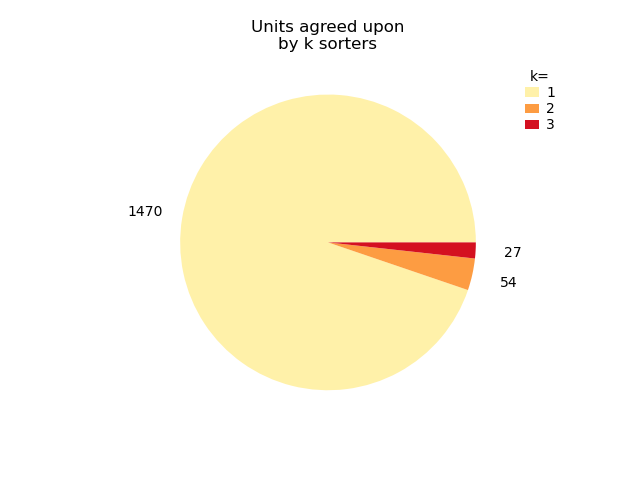

<IPython.core.display.Javascript object>


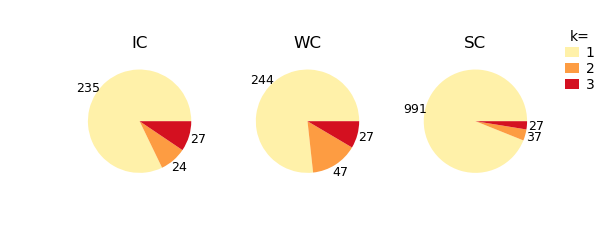

In [8]:
# visualize comaprisons
w = sw.plot_multicomp_agreement(mcmp)
w = sw.plot_multicomp_agreement_by_sorter(mcmp)

In [9]:
# set agreement sorter. min agreement count is the number of sorters that had to agree to count the unit. Default
# is to use 4 (as per the paper)
agreement_sorting = mcmp.get_agreement_sorting(minimum_agreement_count=3)

In [10]:
# get the ids of the common units
ids = agreement_sorting.get_unit_ids()
# show user common unit ids from the primary sorter
print('Common Unit IDs: ', ids)

Common Unit IDs:  [11, 21, 53, 63, 67, 76, 89, 100, 104, 109, 110, 115, 127, 140, 141, 160, 178, 181, 183, 184, 186, 230, 238, 257, 264, 269, 273]


In [11]:
# crucial: cache main sorter and specify location of tmp directory. The tmp directory needs to exist in your system.
# This will eat a lot of space while its processing. I would recomment that you have 2TB+ free in the tmp directory
sorting_IC_cache = se.CacheSortingExtractor(sorting_IC, pjoin(pth, sess, 'processed/ic_sort_results_cache.dat'))
sorting_IC_cache.dump_to_pickle(pjoin(pth, sess, 'processed/ic_sorting_cache.pkl'))
os.makedirs(pjoin(pth, sess, 'processed/tmp/'), exist_ok=True)
sorting_IC_cache.set_tmp_folder(pjoin(pth, sess, 'processed/tmp/'))

In [5]:
sorting_IC_cache = se.load_extractor_from_pickle(pjoin(pth, sess, 'processed/ic_sorting_cache.pkl'))
sorting_IC_cache.set_tmp_folder(pjoin(pth, sess, 'processed/tmp/'))

In [10]:
st.postprocessing.export_to_phy?

In [6]:
# Export the data to phy for manual curation. This should work, but if it crashes, you will need to do the 
# processing separately. Use the code cells at the end of this docuiment to do that, than rerun this cell.
st.postprocessing.export_to_phy(recording_cache, sorting_IC_cache, 
                                output_folder=pjoin(pth, sess, 'processed/phy_IC'), 
                                ms_before=0.5, 
                                ms_after=1, 
                                compute_pc_features=True, 
                                compute_amplitudes=True, 
                                max_spikes_per_unit=None, 
                                compute_property_from_recording=False, 
                                n_jobs=1, 
                                recompute_info=False, 
                                save_property_or_features=False, 
                                verbose=True)

Converting to Phy format
Number of chunks: 84 - Number of jobs: 1


Extracting waveforms in chunks: 100%|#################################################################################################| 84/84 [2:22:27<00:00, 101.75s/it]


Fitting PCA of 3 dimensions on 1196353 waveforms
Projecting waveforms on PC
Saving files
Saved phy format to:  /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/phy_IC
Run:

phy template-gui  /project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/processed/phy_IC/params.py


<IPython.core.display.Javascript object>


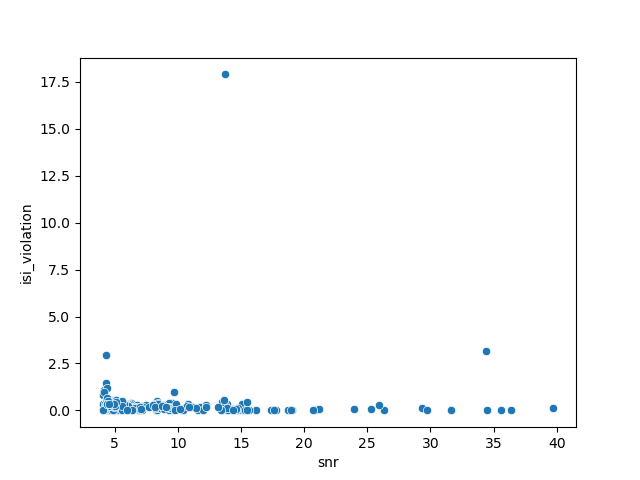

<AxesSubplot:xlabel='snr', ylabel='isi_violation'>

In [6]:
if 'sorting_IC' not in locals():
    sorting_IC = se.load_extractor_from_pickle(pjoin(pth, sess, 'processed/sorting_ic.pkl'))

# quality metrics
import seaborn as sns
# get quality metrics
quality_metrics = st.validation.compute_quality_metrics(sorting_IC, recording_cache, 
                                                        metric_names=['firing_rate', 'isi_violation', 'snr'], 
                                                        as_dataframe=True)
# plot the data
plt.figure()
# you can change these however you want to see the values
sns.scatterplot(data=quality_metrics, x="snr", y='isi_violation')

In [7]:
# Decide thresholds for quality metrics and ID sites that pass criteria
snr_thresh = 5
isi_viol_thresh = 0.5
duration = recording_cache.get_num_frames()
# first get ISI violations and see ids that pass
sorting_auto = st.curation.threshold_isi_violations(sorting_IC, isi_viol_thresh, 'greater', duration)
print('#: ', len(sorting_auto.get_unit_ids()))
print('IDs: ', sorting_auto.get_unit_ids())

#:  263
IDs:  [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 44, 46, 47, 48, 49, 50, 52, 53, 54, 56, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 124, 125, 126, 127, 128, 129, 130, 131, 132, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 204, 205, 206, 207, 208, 209, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 225, 226, 227, 228, 229, 230, 232, 233, 234, 235, 236,

In [8]:
# now threshold on snr, and additionally remove clusters that do not pass
sorting_auto = st.curation.threshold_snrs(sorting_auto, recording_cache, snr_thresh, 'less')
print('#: ', len(sorting_auto.get_unit_ids()))
print('IDs: ', sorting_auto.get_unit_ids())
ids = sorting_auto.get_unit_ids()

#:  160
IDs:  [2, 3, 5, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 41, 44, 46, 47, 48, 49, 52, 53, 54, 56, 58, 59, 62, 63, 64, 67, 68, 70, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 88, 89, 90, 91, 92, 95, 98, 100, 101, 102, 104, 105, 106, 107, 109, 110, 112, 113, 114, 115, 116, 118, 125, 127, 129, 135, 137, 139, 140, 141, 144, 145, 146, 147, 151, 155, 156, 158, 160, 163, 165, 166, 167, 168, 175, 178, 179, 181, 183, 184, 186, 188, 190, 192, 193, 195, 197, 199, 200, 202, 204, 205, 208, 209, 211, 213, 215, 216, 218, 221, 222, 227, 228, 230, 232, 235, 237, 238, 239, 245, 246, 247, 248, 249, 251, 254, 257, 258, 259, 260, 261, 264, 265, 267, 269, 271, 273, 275, 276, 277, 281, 282]


In [11]:
ids = sorting_auto.get_unit_ids()

In [12]:
# Auto label based on criteria and comparision analysis. We do that by labelling all clusters that passed our
# criteria as MUA. Then we go back and label all clusters that were found in all sorters as 'Good'(SU).
cfile = pjoin(pth, sess, 'processed/phy_IC/cluster_group.tsv')
cg = pd.read_csv(cfile, delimiter='\t')
cg.iloc[sorting_auto.get_unit_ids(), 1] = 'mua'
cg.iloc[ids, 1] = 'good'
cg.to_csv(cfile, index=False, sep='\t') # check to see if the correct units were marked

### Done!
You should now use Phy to manually curate the results. I recommend having Phy installed in a seprate environment. When you open Phy, all of the clusters should be labeled "mua" (gray), "good" (green), or unlabeled (white). They can also be labeled "noise" (dark gray). You can now go through and adjust the automated curation. You want to check that good units are indeed single units to you, and that none of the mua are actually single units. You also want to check for errors (which should be rare) like: A cluster needs to be split into two. Two clusters need to be mereged. The cluster is really some weird noise. A cluster acually has labeled the same events as another cluster. Remeber to save your work in phy through the menu often.

### Saving the output/working with the data

After completing the manual curation we can access the spike info directly from phy using python (phy output is in .npy) or matlab (using the numpy toolbox). Or you can reimport the data form phy and save as nwb or access directy (the spikeinterface format is really neo under the hood). The NWB part is still a work in progress and may be problematic. The method attempted here is to save the processed data. then append the sorted data to the NWB file created for the processed data.

In [10]:
import matplotlib.pyplot as plt
import spikeinterface
import spikeinterface.extractors as se 
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import numpy as np
import pandas as pd
from os.path import join as pjoin
import os
import glob
import pynwb
sorting_IC_phy._properties
#(unit_ids=unitIDs, property_name='group')

{0: {'chan_group': '0', 'quality': 'noise'},
 1: {'chan_group': '0', 'quality': 'good'},
 3: {'chan_group': '0', 'quality': 'mua'},
 4: {'chan_group': '0', 'quality': 'mua'},
 7: {'chan_group': '0', 'quality': 'mua'},
 9: {'chan_group': '0', 'quality': 'mua'},
 12: {'chan_group': '0', 'quality': 'mua'},
 13: {'chan_group': '0', 'quality': 'mua'},
 16: {'chan_group': '0', 'quality': 'good'},
 17: {'chan_group': '0', 'quality': 'mua'},
 20: {'chan_group': '0', 'quality': 'mua'},
 21: {'chan_group': '0', 'quality': 'mua'},
 23: {'chan_group': '0', 'quality': 'mua'},
 25: {'chan_group': '0', 'quality': 'mua'},
 26: {'chan_group': '0', 'quality': 'mua'},
 27: {'chan_group': '0', 'quality': 'mua'},
 34: {'chan_group': '0', 'quality': 'good'},
 35: {'chan_group': '0', 'quality': 'mua'},
 36: {'chan_group': '0', 'quality': 'mua'},
 39: {'chan_group': '0', 'quality': 'mua'},
 41: {'chan_group': '0', 'quality': 'mua'},
 43: {'chan_group': '0', 'quality': 'noise'},
 47: {'chan_group': '0', 'quali

In [12]:
sorting_IC_phy._properties
#(unit_ids=unitIDs, property_name='group')

{0: {'group': 1, 'quality': 'unsorted'},
 1: {'group': 1, 'quality': 'unsorted'},
 2: {'group': 1, 'quality': 'unsorted'},
 3: {'group': 2, 'quality': 'unsorted'},
 4: {'group': 2, 'quality': 'mua'},
 5: {'group': 2, 'quality': 'mua'},
 6: {'group': 2, 'quality': 'mua'},
 7: {'group': 2, 'quality': 'mua'},
 8: {'group': 2, 'quality': 'mua'},
 9: {'group': 2, 'quality': 'unsorted'},
 10: {'group': 2, 'quality': 'unsorted'},
 11: {'group': 2, 'quality': 'unsorted'},
 12: {'group': 3, 'quality': 'unsorted'},
 13: {'group': 3, 'quality': 'unsorted'},
 14: {'group': 3, 'quality': 'mua'},
 15: {'group': 3, 'quality': 'mua'},
 16: {'group': 3, 'quality': 'good'},
 17: {'group': 4, 'quality': 'mua'},
 18: {'group': 4, 'quality': 'mua'},
 19: {'group': 5, 'quality': 'mua'},
 20: {'group': 5, 'quality': 'mua'},
 21: {'group': 5, 'quality': 'mua'},
 22: {'group': 5, 'quality': 'mua'},
 23: {'group': 5, 'quality': 'mua'},
 24: {'group': 6, 'quality': 'unsorted'},
 25: {'group': 6, 'quality': 'mua'

In [ ]:
# Append the sorting data to the NWB file by using setting the overwrite argument to False
# import phy curation

#sorting_IC_phy = se.PhySortingExtractor('/scratch/midway3/daltonm/phy_sorting_by_paul/phy_IC/')
#sorting_IC_phy = se.PhySortingExtractor('/scratch/midway3/daltonm/phy_sorting_by_paul/phy_IC/', exclude_cluster_groups='noise')
#sorting_IC_phy = se.PhySortingExtractor('/project2/nicho/dalton/phy_sorting_by_paul/phy_IC/', exclude_cluster_groups=['noise', 'mua'])
sorting_IC_phy = se.PhySortingExtractor('/project/nicho/data/marmosets/electrophys_data_for_processing/TY20210211_freeAndMoths/phy_TDC/', exclude_cluster_groups=['noise', 'mua'])

#nwb_file = '/project/nicho/data/marmosets/electrophys_data_for_processing/TY20221024_testbattery/TY20221024_testbattery_001_NWBTEST_only_neural_converters_NEWWWWW.nwb'
#nwb_file = '/project2/nicho/marmoset_tempStorage/electrophys_data_for_processing/TY20221024_testbattery/TY20221024_testbattery_001_PHY.nwb'
nwb_file = '/project/nicho/data/marmosets/electrophys_data_for_processing/TY20210211_freeAndMoths/TY20210211_freeAndMoths-003_PHYTEST.nwb'

unitIDs = sorting_IC_phy.get_unit_ids()
#sorting_IC_phy.set_units_property(unit_ids=unitIDs, 
#                                  property_name='channel_index', 
#                                  values=sorting_IC_phy.get_units_property(unit_ids=unitIDs, property_name='group'))
#se.NwbSortingExtractor.write_sorting(sorting_IC_phy, nwb_file, overwrite=False)

In [ ]:
sorting_IC_phy.set_units_property(unit_ids=unitIDs, 
                                  property_name='channel_index', 
                                  values=sorting_IC_phy.get_units_property(unit_ids=unitIDs, property_name='group'))


# Extra cells that might be helpful

If export to phy crashes, try running these next three cells first, then retry export to phy.

In [ ]:
# get waveforms for chosen sorter
st.postprocessing.get_unit_waveforms(recording_cache, sorting_IC_cache, 
                                     ms_before=0.5, 
                                     ms_after=1, 
                                     compute_property_from_recording=True, 
                                     n_jobs=10, 
                                     max_spikes_per_unit=None, 
                                     memmap=True, 
                                     save_property_or_features=True, 
                                     recompute_info=True, 
                                     verbose=True)

In [ ]:
# get amplitudes for chosen sorter
st.postprocessing.get_unit_amplitudes(recording_cache, sorting_IC_cache, 
                                      ms_before=0.5, 
                                      ms_after=1, 
                                      max_spikes_per_unit=None, 
                                      memmap=True, 
                                      save_property_or_features=True, 
                                      n_jobs=10, 
                                      verbose=True)

In [ ]:
# unit templates
st.postprocessing.get_unit_templates(recording_cache, sorting_IC_cache, 
                                     ms_before=0.5, 
                                     ms_after=1, 
                                     max_spikes_per_unit=None, 
                                     memmap=True, 
                                     save_property_or_feature=True, 
                                     n_jobs=10, 
                                     verbose=True)

In case the isi violations throws an error, try running these cells first

In [ ]:
duration = recording_cache.get_num_frames()
isi_violations = st.validation.compute_isi_violations(sorting_IC, duration_in_frames=duration)
print('ISI violations:', isi_violations)

snrs = st.validation.compute_snrs(sorting_IC, recording_cache)
print('SNRs:', snrs)